In [3]:
#!g1.1
tf.__version__

'2.10.1'

In [29]:
!pip install pydot
!pip install graphviz 

     ---------------------------------------- 47.0/47.0 kB 1.2 MB/s eta 0:00:00


In [2]:
#!g1.1
import numpy as np

import os

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Flatten, Reshape, Dense, InputLayer, BatchNormalization, Dropout, Activation
from tensorflow.keras.layers import Subtract, Concatenate, Add
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam, Adamax
#from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

#from PIL import Image

%matplotlib inline

In [2]:
#test
path_img = './imagenet/imagenet/train/'
images = []
img_size = (256, 256)

i = 0
for filename in os.listdir(path_img):
    images.append(image.load_img(os.path.join(path_img, filename), target_size=img_size, keep_aspect_ratio=True))
    
    i+=1
    if i==2000: break

In [13]:
#!g1.1
def add_noise_and_convert_to_array (input_img, noise_factor=None, norm=True):
    x_images_clear = []
    x_images_noised = []
    for img in input_img:
        if noise_factor == None:
            noise_factor = np.random.uniform(0.1, 0.3)
        img_np = (image.img_to_array(img)) #.astype('float32')
        igm_np = img_np.astype('float32')
        if norm:
            val_upper = 1.
            img_np /= 255.
        else:
            #img_np = img_np.astype('int')
            val_upper = 255.
        x_images_clear.append(img_np)
        noise = noise_factor*val_upper*K.random_normal(img_np.shape, mean=0., stddev=1.0)               
        #noise = np.zeros(img_np.shape)
        #for element in noise:
        #    element = rng.rvs()
        img_noised = img_np + noise
        img_noised = K.clip(img_noised, 0., val_upper)
        x_images_noised.append(img_noised)
    return np.array(x_images_clear), np.array(x_images_noised)

images_clear, images_noised = add_noise_and_convert_to_array(images, norm=True)

In [3]:
#np.save('images_clear', images_clear)
#np.save('images_noised', images_noised)
images_clear = np.load('images_clear.npy')
images_noised = np.load('images_noised.npy')

In [3]:
images_clear.shape

(2000, 256, 256, 3)

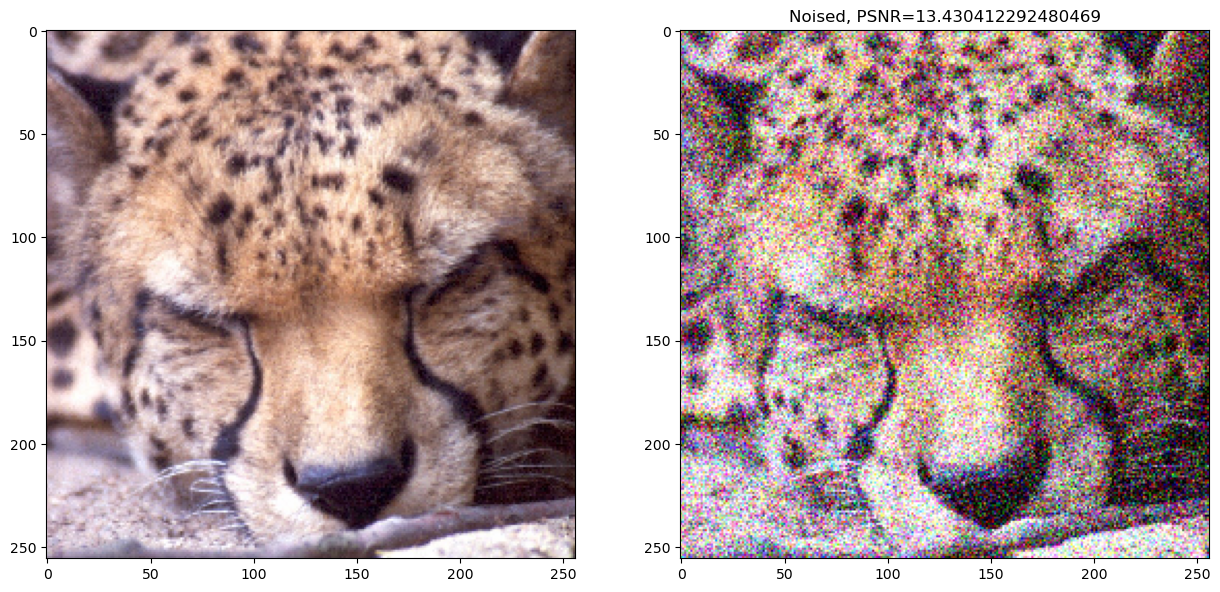

In [4]:
#!g1.1
n=5
max_value=1.
plt.subplots(1,2, figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(image.array_to_img(images_clear[n]))
plt.subplot(1,2,2)
plt.title(f'Noised, PSNR={tf.image.psnr(images_clear[n], images_noised[n], max_val=max_value)}')
plt.imshow(image.array_to_img(images_noised[n]))
#image.save_img('t.jpg', image.array_to_img(images_noised[n]))
#image.save_img('tc.jpg', image.array_to_img(images_clear[n]))

In [ ]:
#!g1.1
#model = tf.keras.models.load_model('/kaggle/working/ae_v2_adamax_gelu_100_0.0054')
#model.summary()

In [5]:
def plot_history(history):
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend()
    plt.show()

In [6]:
def psnr_loss(y_true, y_pred):
    return 1/tf.image.psnr(y_true, y_pred, max_val=255)

def ssim_loss(y_true, y_pred):
    return 1/tf.image.ssim(y_true, y_pred, max_val=1)

def ssim_l2(y_true, y_pred):
    ssim = 1. - tf.math.log(tf.image.ssim(y_true, y_pred, max_val=1.))
    l2 = tf.keras.losses.mean_squared_error(y_true, y_pred)
    return ssim + l2

def wloss(y_true, y_pred):
    return K.mean(y_true*y_pred)

combine_loss = ['mae', ssim_loss]

In [7]:
#!g1.1
def plot_result(image_clear, image_noised, image_reconstructed, max_value=255):
    plt.subplots(1,3, figsize=(15, 15))
    plt.subplot(1,3,1)
    plt.imshow(image_clear)
    #plt.imshow(image.array_to_img(image_clear))
    #plt.imshow(image_clear)
    plt.title(f'Ground True')
    plt.subplot(1,3,2)
    plt.imshow(image_noised)
    plt.title(f'Noised, PSNR={tf.image.psnr(image_clear, image_noised, max_val=max_value)}')
    plt.subplot(1,3,3)
    plt.imshow(image_reconstructed)
    plt.title(f'Reconstructed, PSNR={tf.image.psnr(image_clear, image_reconstructed, max_val=max_value)}')

In [8]:
def calc_mean_image_metrics(images_clear, images_reconstructed, max_value):
    psnrs = []
    ssims = []
    for i in range(images_reconstructed.shape[0]):
        psnr = tf.image.psnr(images_clear[i], images_reconstructed[i], max_val=max_value)
        psnrs.append(psnr)
        ssim = tf.image.ssim(images_clear[i], images_reconstructed[i], max_val=max_value)
        ssims.append(ssim)
    return np.mean(np.array(psnrs)), np.mean(np.array(ssims))

In [9]:
def predict_all(model, x):
    yy = []
    for i in range(x.shape[0]):
        image = x[i][np.newaxis, :]
        y = model.predict(image)
        yy.append(y[0])
    return np.array(yy)

# Autoencoder

In [32]:
#!g1.1
img_shape=(256, 256, 3)

input = Input(img_shape)
encode = Conv2D(256, kernel_size=(3,3), padding='same')(input)
encode = BatchNormalization()(encode)
encode = Activation('gelu')(encode)
encode = MaxPooling2D(pool_size=(2,2))(encode)
encode = Conv2D(256, kernel_size=(3,3), padding='same')(encode)
encode = BatchNormalization()(encode)
encode = Activation('gelu')(encode)
encode = MaxPooling2D(pool_size=(2,2))(encode)

decode = Conv2DTranspose(256, kernel_size=(3,3), strides=2, padding='same')(encode)
decode = BatchNormalization()(decode)
decode = Activation('gelu')(decode)
decode = Conv2DTranspose(256, kernel_size=(3,3), strides=2, padding='same')(decode)
decode = BatchNormalization()(decode)
decode = Activation('gelu')(decode)

out = Conv2DTranspose(3, kernel_size=(3,3), activation='sigmoid', padding='same')(decode)

ae = Model(input, out)

ae.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 256, 256, 256)     7168      
                                                                 
 batch_normalization_15 (Bat  (None, 256, 256, 256)    1024      
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 256, 256, 256)     0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 256)    0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 128, 128, 256)     5900

Epoch 1/30
1600/1600 [==============================] - 154s 92ms/step - loss: 1.7592 - val_loss: 1.5770 - lr: 0.0100
Epoch 2/30
1600/1600 [==============================] - 141s 88ms/step - loss: 1.5870 - val_loss: 1.5334 - lr: 0.0100
Epoch 3/30
1600/1600 [==============================] - 142s 89ms/step - loss: 1.5380 - val_loss: 1.4993 - lr: 0.0100
Epoch 4/30
1600/1600 [==============================] - 145s 91ms/step - loss: 1.5048 - val_loss: 1.4545 - lr: 0.0100
Epoch 5/30
1600/1600 [==============================] - 147s 92ms/step - loss: 1.4777 - val_loss: 1.4912 - lr: 0.0100
Epoch 6/30
1600/1600 [==============================] - 148s 92ms/step - loss: 1.4615 - val_loss: 1.4719 - lr: 0.0100
Epoch 7/30
1600/1600 [==============================] - 148s 92ms/step - loss: 1.4467 - val_loss: 1.4242 - lr: 0.0100
Epoch 8/30
1600/1600 [==============================] - 146s 92ms/step - loss: 1.4375 - val_loss: 1.4446 - lr: 0.0100
Epoch 9/30
1600/1600 [==============================] - 

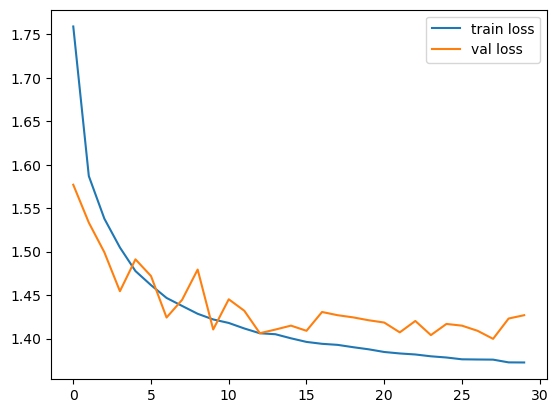

In [33]:
#!g1.1
reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss',
                                        factor=0.1,
                                        patience=5) #,
                                        #min_lr=1e-10)

ae.compile(optimizer=Adamax(learning_rate=1e-2), loss=ssim_l2)

history = ae.fit(images_noised, images_clear,
                epochs=30,
                #initial_epoch=76,
                callbacks=[reduce_lr],
                validation_split=0.2,
                batch_size=1)

plot_history(history)

In [34]:
y = predict_all(ae, images_noised)

1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 47ms/step


mean PSNR=22.35626220703125
mean SSIM=0.6677693128585815


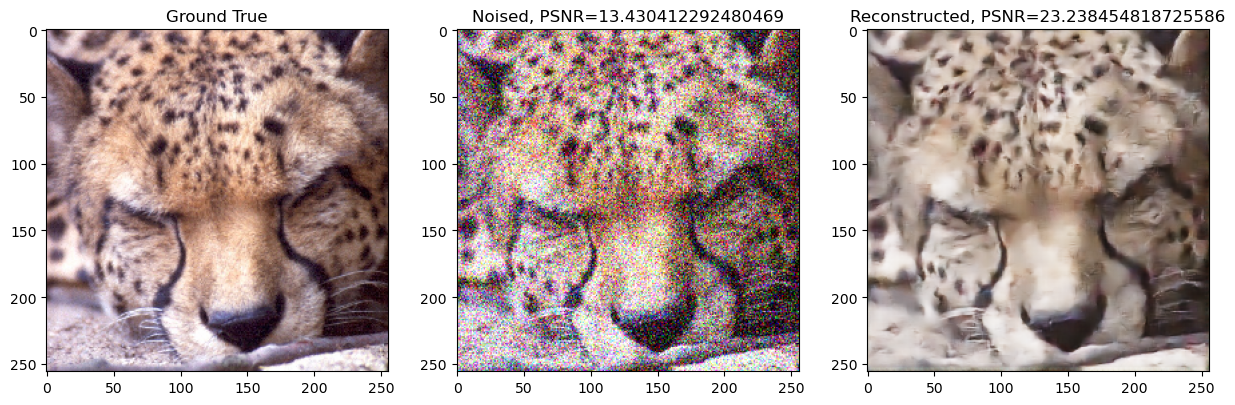

In [35]:
#!g1.1
n=5
max_value=1
psnr, ssim = calc_mean_image_metrics(images_clear, y, max_value=max_value)
print (f'mean PSNR={psnr}')
print (f'mean SSIM={ssim}')
plot_result(images_clear[n],
            images_noised[n],
            y[n],
            max_value=max_value
           )

In [43]:
ae_v3.save('ae_v3_adamax_gelu_no_activ_out_no_norm_mae_150_10.39_best')

INFO:tensorflow:Assets written to: ae_v3_adamax_gelu_no_activ_out_no_norm_mae_150_10.39_best\assets


INFO:tensorflow:Assets written to: ae_v3_adamax_gelu_no_activ_out_no_norm_mae_150_10.39_best\assets


In [ ]:
ae_v2.optimizer.variables()

# dnCNN

In [9]:
img_shape=(256, 256, 3)
input = Input(img_shape)
hidden = 16
x = Conv2D(128, kernel_size=(3,3), padding='same')(input)
x = Activation('gelu')(x)
for i in range(hidden):
    x = Conv2D(128, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('gelu')(x)
x = Conv2D(3, kernel_size=(3,3), padding='same')(x)
out = Subtract()([input, x])

dncnn = Model(input, out)
dncnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 12  3584        ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 activation (Activation)        (None, 256, 256, 12  0           ['conv2d[0][0]']                 
                                8)                                                            

                                                                                                  
 conv2d_9 (Conv2D)              (None, 256, 256, 12  147584      ['activation_8[0][0]']           
                                8)                                                                
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 256, 256, 12  512        ['conv2d_9[0][0]']               
 rmalization)                   8)                                                                
                                                                                                  
 activation_9 (Activation)      (None, 256, 256, 12  0           ['batch_normalization_8[0][0]']  
                                8)                                                                
                                                                                                  
 conv2d_10

In [9]:
def dncnn_res(img_shape):

    input = Input(img_shape)
    hidden = 16
    x = Conv2D(128, kernel_size=(3,3), padding='same')(input)
    x = Activation('gelu')(x)
    for i in range(hidden):
        xx = Conv2D(128, kernel_size=(3,3), padding='same')(x)
        xx = BatchNormalization()(xx)
        xx = Activation('gelu')(xx)
        xx = Add()([x, xx])
        x = xx
    x = Conv2D(3, kernel_size=(3,3), padding='same')(x)
    out = Subtract()([input, x])

    model = Model(input, out)
    model.summary()
    return model
#dncnn = dncnn_res((256,256,3))

In [11]:
dncnn = dncnn_res((256,256,3))
reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss',
                                        factor=0.1,
                                        patience=5) #,
                                        #min_lr=1e-10)

dncnn.compile(optimizer=Adamax(learning_rate=1e-2), loss=ssim_l2)

history = dncnn.fit(images_noised, images_clear,
                epochs=30,
                #initial_epoch=76,
                callbacks=[reduce_lr],
                validation_split=0.2,
                shuffle=True,
                batch_size=1)

plot_history(history)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 256, 256, 12  3584        ['input_2[0][0]']                
                                8)                                                                
                                                                                                  
 activation_17 (Activation)     (None, 256, 256, 12  0           ['conv2d_18[0][0]']              
                                8)                                                          

                                                                                                  
 conv2d_25 (Conv2D)             (None, 256, 256, 12  147584      ['add_21[0][0]']                 
                                8)                                                                
                                                                                                  
 batch_normalization_22 (BatchN  (None, 256, 256, 12  512        ['conv2d_25[0][0]']              
 ormalization)                  8)                                                                
                                                                                                  
 activation_24 (Activation)     (None, 256, 256, 12  0           ['batch_normalization_22[0][0]'] 
                                8)                                                                
                                                                                                  
 add_22 (A

                                8)                                'activation_30[0][0]']          
                                                                                                  
 conv2d_32 (Conv2D)             (None, 256, 256, 12  147584      ['add_28[0][0]']                 
                                8)                                                                
                                                                                                  
 batch_normalization_29 (BatchN  (None, 256, 256, 12  512        ['conv2d_32[0][0]']              
 ormalization)                  8)                                                                
                                                                                                  
 activation_31 (Activation)     (None, 256, 256, 12  0           ['batch_normalization_29[0][0]'] 
                                8)                                                                
          

KeyboardInterrupt: 

In [11]:
y = predict_all(dncnn, images_noised)

1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 200ms/step


1/1 [==============================] - 0s 204ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 1s 803ms/step


1/1 [==============================] - 0s 180ms/step


mean PSNR=21.895164489746094
mean SSIM=0.6157948970794678


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


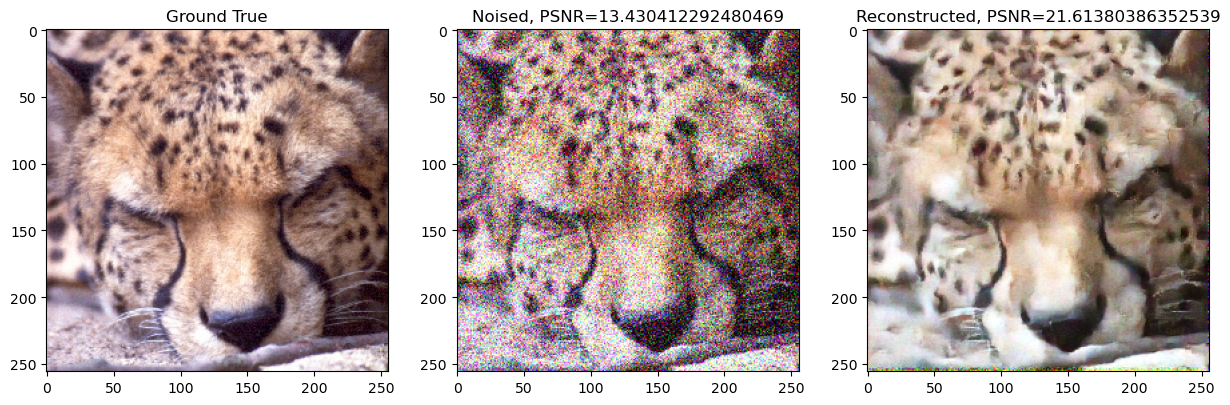

In [12]:
n=5
max_value=1
psnr, ssim = calc_mean_image_metrics(images_clear, y, max_value=max_value)
print (f'mean PSNR={psnr}')
print (f'mean SSIM={ssim}')
plot_result(images_clear[n],
            images_noised[n],
            y[n],
            max_value=max_value
           )

# RAW

In [52]:
!pip install rawpy
!pip install imageio

     -------------------------------------- 793.6/793.6 kB 6.3 MB/s eta 0:00:00


In [70]:
import rawpy
import scipy as sp
import statsmodels


In [75]:
raw = rawpy.imread('raw_noise/high_iso/test_0001.CR3')

(4498, 6742, 3)


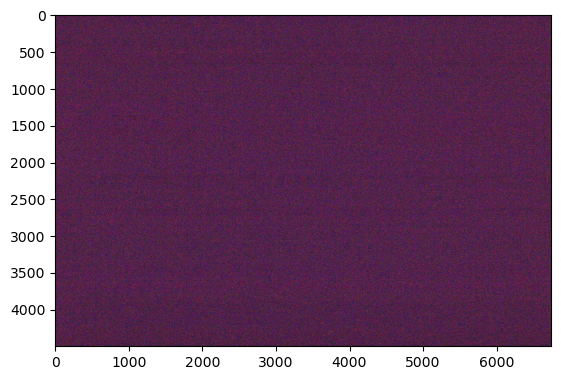

In [76]:
rgb = raw.postprocess(use_camera_wb=True, output_color=rawpy.ColorSpace.sRGB)
print (rgb.shape)
plt.imshow(rgb)

In [77]:
vec=rgb.flatten()

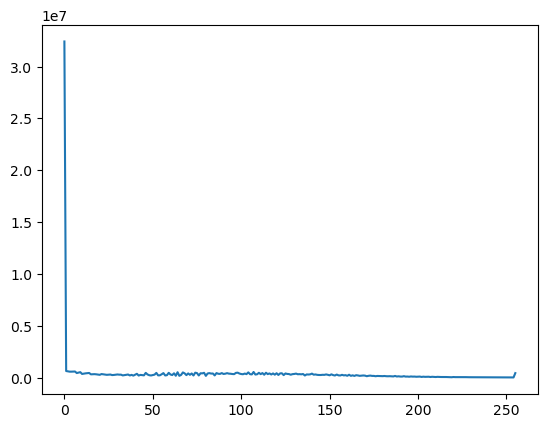

In [79]:
vec_counts = np.unique(vec, return_counts=True)
plt.plot(vec_counts[0], vec_counts[1])

{'whiskers': [<matplotlib.lines.Line2D at 0x1f488d26a30>,
 'caps': [<matplotlib.lines.Line2D at 0x1f488d26fd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f488d26760>],
 'medians': [<matplotlib.lines.Line2D at 0x1f488d4e5b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f488d4e880>],
 'means': []}

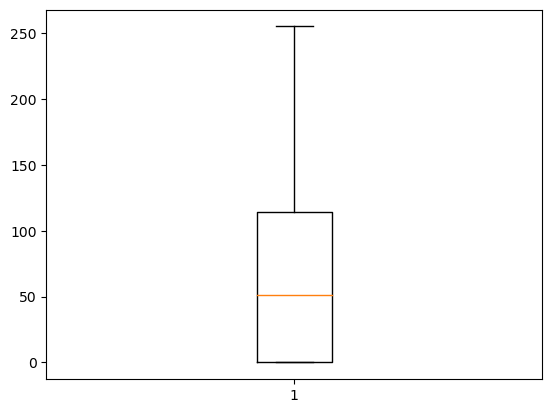

In [73]:
plt.boxplot(vec)

In [80]:
from scipy.stats.sampling import DiscreteGuideTable

In [84]:
vec

array([  0,  99,   0, ...,   0, 106,   0], dtype=uint8)

1.0000000000000004


(array([4540.,  777.,  970., 1016.,  939.,  753.,  461.,  287.,  134.,
         123.]),
 array([  0. ,  24.4,  48.8,  73.2,  97.6, 122. , 146.4, 170.8, 195.2,
        219.6, 244. ]),
 <BarContainer object of 10 artists>)

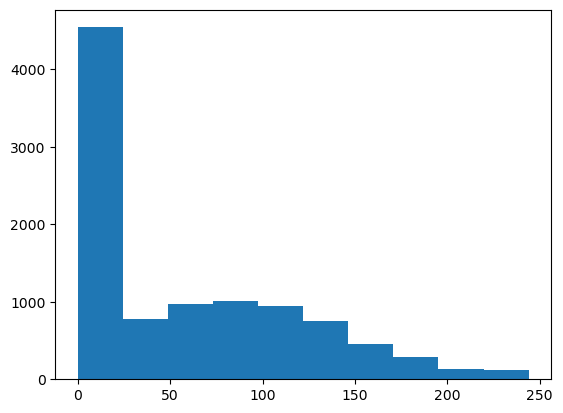

In [85]:
vec_p = vec_counts[1]/len(vec)
print (sum(vec_p))
rng = DiscreteGuideTable(vec_p)

xx = []
for i in range(10000):
    xx.append(rng.rvs())
    
plt.hist(xx)

In [183]:
def noise():
    x = rng.rvs()
    print (x)
    yield x
    
    
x = np.fromiter(noise()) #, dtype=(int, (1,10)))
x

TypeError: fromiter() missing required argument 'dtype' (pos 2)

In [181]:
def cut_image(image):
    subimages = []
    
    
    return subimages

# Unet

In [12]:
def model_unet(img_shape):
    
    input = Input(img_shape)

    conv1_1 = Conv2D(64, kernel_size=(2,2), activation='relu', padding='same')(input)
    conv1_2 = Conv2D(64, kernel_size=(2,2), activation='relu', padding='same')(conv1_1)
    conv1_p = MaxPooling2D(2,2)(conv1_2)
    conv1_bn = BatchNormalization()(conv1_p)

    conv2_1 = Conv2D(128, kernel_size=(2,2), activation='relu', padding='same')(conv1_bn)
    conv2_2 = Conv2D(128, kernel_size=(2,2), activation='relu', padding='same')(conv2_1)
    conv2_p = MaxPooling2D(2,2)(conv2_2)
    conv2_bn = BatchNormalization()(conv2_p)

    conv3_1 = Conv2D(256, kernel_size=(2,2), activation='relu', padding='same')(conv2_bn)
    conv3_2 = Conv2D(256, kernel_size=(2,2), activation='relu', padding='same')(conv3_1)
    conv3_p = MaxPooling2D(2,2)(conv3_2)
    conv3_bn = BatchNormalization()(conv3_p)

    conv4_1 = Conv2D(512, kernel_size=(2,2), activation='relu', padding='same')(conv3_bn)
    conv4_2 = Conv2D(512, kernel_size=(2,2), activation='relu', padding='same')(conv4_1)
    conv4_p = MaxPooling2D(2,2)(conv4_2)
    conv4_bn = BatchNormalization()(conv4_p)

    conv_btnk = Conv2D(1024, kernel_size=(2,2), activation='relu', padding='same')(conv4_bn)
    conv_btnk = Conv2D(1024, kernel_size=(2,2), activation='relu', padding='same')(conv_btnk)

    upconv4_1 = Conv2DTranspose(512, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(conv_btnk)
    upconv4_concat = Add()([upconv4_1, conv4_2])
    upconv4_bn = BatchNormalization()(upconv4_concat)
    upconv4_2 = Conv2D(512, kernel_size=(2,2), activation='relu', padding='same')(upconv4_bn)
    upconv4_3 = Conv2D(512, kernel_size=(2,2), activation='relu', padding='same')(upconv4_2)

    upconv3_1 = Conv2DTranspose(256, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(upconv4_3)
    upconv3_concat = Add()([upconv3_1, conv3_2])
    upconv3_bn = BatchNormalization()(upconv3_concat)
    upconv3_2 = Conv2D(256, kernel_size=(2,2), activation='relu', padding='same')(upconv3_bn)
    upconv3_3 = Conv2D(256, kernel_size=(2,2), activation='relu', padding='same')(upconv3_2)

    upconv2_1 = Conv2DTranspose(128, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(upconv3_3)
    upconv2_concat = Add()([upconv2_1, conv2_2])
    upconv2_bn = BatchNormalization()(upconv2_concat)
    upconv2_2 = Conv2D(128, kernel_size=(2,2), activation='relu', padding='same')(upconv2_bn)
    upconv2_3 = Conv2D(128, kernel_size=(2,2), activation='relu', padding='same')(upconv2_2)

    upconv1_1 = Conv2DTranspose(64, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(upconv2_3)
    upconv1_concat = Add()([upconv1_1, conv1_2])
    upconv1_bn = BatchNormalization()(upconv1_concat)
    upconv1_2 = Conv2D(64, kernel_size=(2,2), activation='relu', padding='same')(upconv1_bn)
    upconv1_3 = Conv2D(64, kernel_size=(2,2), activation='relu', padding='same')(upconv1_2)

    conv_out = Conv2D(3, kernel_size=(1,1), activation='relu', padding='same')(upconv1_3)
    #out = Add()([input, conv_out])
    out = conv_out

    model = Model(input, out)
    model.summary()
    
    return model

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 256, 256, 64  832         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_37 (Conv2D)             (None, 256, 256, 64  16448       ['conv2d_36[0][0]']              
                                )                                                           

                                8)                                'conv2d_39[0][0]']              
                                                                                                  
 batch_normalization_38 (BatchN  (None, 128, 128, 12  512        ['add_34[0][0]']                 
 ormalization)                  8)                                                                
                                                                                                  
 conv2d_50 (Conv2D)             (None, 128, 128, 12  65664       ['batch_normalization_38[0][0]'] 
                                8)                                                                
                                                                                                  
 conv2d_51 (Conv2D)             (None, 128, 128, 12  65664       ['conv2d_50[0][0]']              
                                8)                                                                
          

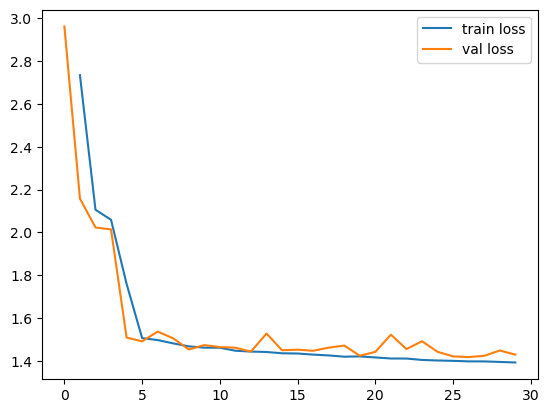

In [13]:
unet = model_unet((256, 256, 3))
reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss',
                                        factor=0.1,
                                        patience=5) #,
                                        #min_lr=1e-10)

unet.compile(optimizer=Adamax(learning_rate=1e-2), loss=ssim_l2)

history = unet.fit(images_noised, images_clear,
                epochs=30,
                callbacks=[reduce_lr],
                validation_split=0.2,
                #huffle=True,
                batch_size=1)

plot_history(history)

In [14]:
y = predict_all(unet, images_noised)

1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 367ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 53ms/step


mean PSNR=21.322179794311523
mean SSIM=0.6651113629341125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


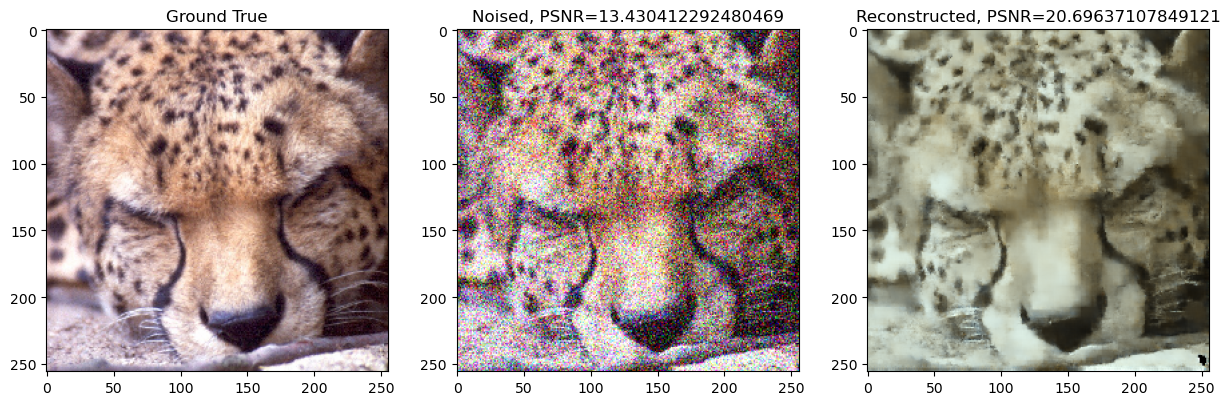

In [15]:
n=5
max_value=1
psnr, ssim = calc_mean_image_metrics(images_clear, y, max_value=max_value)
print (f'mean PSNR={psnr}')
print (f'mean SSIM={ssim}')
plot_result(images_clear[n],
            images_noised[n],
            y[n],
            max_value=max_value
           )

# GAN

In [10]:
def dncnn_res_gan(img_shape):

    input = Input(img_shape)
    hidden = 8
    x = Conv2D(64, kernel_size=(3,3), padding='same')(input)
    x = LeakyReLU(0.2)(x)
    for i in range(hidden):
        xx = Conv2D(64, kernel_size=(3,3), padding='same')(x)
        xx = BatchNormalization()(xx)
        xx = LeakyReLU(0.2)(xx)
        xx = Add()([x, xx])
        x = xx
    x = Conv2D(3, kernel_size=(3,3), activation='sigmoid', padding='same')(x)
    #out = Subtract()([input, x])
    out = x

    model = Model(input, out)
    model.summary()
    return model

In [11]:
def generator():
    #model = model_unet((256, 256, 3))
    model = dncnn_res_gan((256,256,3))  
    return model

In [12]:
def discriminator():
    img_shape=(256, 256, 3)

    input = Input(img_shape)
    x = Conv2D(64, kernel_size=(3,3), padding='same')(input)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D()(x)
    x = Conv2D(128, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D()(x)
    x = Conv2D(256, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D()(x)
    x = Conv2D(512, kernel_size=(3,3), padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.5)(x)
    x = MaxPooling2D()(x)
    
    x = Flatten()(x)
    x = Dense(1024)(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
    model.summary()
    return model

In [13]:
class denoiser_gan(Model):
    
    img_shape = (256, 256, 3)
    
    def __init__(self, generator, discriminator):
        super (denoiser_gan, self).__init__()
        self.G = generator
        self.D = discriminator
        
    def compile (self, g_optimizer, d_optimizer, loss):
        super(denoiser_gan, self).compile()
        self.G.optimizer = g_optimizer
        self.D.optimizer = d_optimizer
        self.G.loss = loss
        self.D.loss = loss
        self.loss = loss
        
        
    
    def train_step(self, data):        
        images_noised, images_clear = data

        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:

            images_reconstructed = self.G(images_noised, training=True)

            real_out = self.D(images_clear  + 0.05 * tf.random.uniform(tf.shape(images_reconstructed)), training=True)
            #fake_out = self.D(images_reconstructed, training=True)
            fake_out = self.D(images_reconstructed + 0.05 * tf.random.uniform(tf.shape(images_reconstructed)), training=True)

            d_real_loss = self.loss(tf.ones_like(real_out), real_out)
            d_fake_loss = self.loss(tf.zeros_like(fake_out), fake_out)
            d_loss = d_real_loss + d_fake_loss
                        
            g_loss_adv = self.loss(tf.ones_like(fake_out), fake_out)
            #g_loss_content = tf.losses.MeanAbsoluteError()(images_clear, images_reconstructed)
            g_loss_content = ssim_l2(images_clear, images_reconstructed)
            g_loss = g_loss_adv + g_loss_content
            
            
        g_grads = g_tape.gradient(g_loss, self.G.trainable_variables)
        d_grads = d_tape.gradient(d_loss, self.D.trainable_variables)
        
        self.G.optimizer.apply_gradients(zip(g_grads, self.G.trainable_variables))
        self.D.optimizer.apply_gradients(zip(d_grads, self.D.trainable_variables))
        
        ssim = tf.image.ssim(images_clear, images_reconstructed, max_val=1.)
        
        #return {"d_r": d_real_loss, "d_f" :d_fake_loss, "g_loss": g_loss, "ssim" : ssim}
        return {"d": d_loss, "g_adv" :g_loss_adv, "g_cont": g_loss_content, "g_loss": g_loss, "ssim" : ssim}
            
    def call(self, inputs):
        return self.G(inputs)
    
    def predict(self, inputs):
        return self.G.predict(inputs)
    
    #############################   tf.print()

In [14]:
batch_size = 1
G = generator()
D = discriminator()
dngan = denoiser_gan(G, D)
g_opt = Adam(learning_rate=2e-4, beta_1=0.5)
d_opt = Adam(learning_rate=1e-4, beta_1=0.5)
loss = tf.keras.losses.BinaryCrossentropy()

#D.compile(d_opt, loss)
#G.compile(g_opt, loss)
#dngan.compile(Adam(learning_rate=2e-4, beta_1=0.5), loss)
dngan.compile(g_opt, d_opt, loss)
history = dngan.fit(images_noised[:100], images_clear[:100],
                    epochs=3000,
                    batch_size=1
                   )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 conv2d_7 (Conv2D)              (None, 256, 256, 64  36928       ['add_5[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 256, 256, 64  256        ['conv2d_7[0][0]']               
 rmalization)                   )                                                                 
                                                                                                  
 leaky_re_lu_7 (LeakyReLU)      (None, 256, 256, 64  0           ['batch_normalization_6[0][0]']  
                                )                                                                 
                                                                                                  
 add_6 (Ad

100/100 [==============================] - 13s 126ms/step - d: 1.8072 - g_adv: 5.5074 - g_mae: 0.2886 - g_loss: 5.7959 - ssim: 0.1910
Epoch 13/3000
100/100 [==============================] - 13s 126ms/step - d: 1.1879 - g_adv: 5.7260 - g_mae: 0.2815 - g_loss: 6.0075 - ssim: 0.2264
Epoch 14/3000
100/100 [==============================] - 13s 126ms/step - d: 1.4462 - g_adv: 5.7962 - g_mae: 0.2966 - g_loss: 6.0928 - ssim: 0.1724
Epoch 15/3000
100/100 [==============================] - 13s 133ms/step - d: 1.2706 - g_adv: 5.3625 - g_mae: 0.2221 - g_loss: 5.5846 - ssim: 0.2607
Epoch 16/3000
100/100 [==============================] - 13s 131ms/step - d: 0.8761 - g_adv: 4.8242 - g_mae: 0.2432 - g_loss: 5.0674 - ssim: 0.2323
Epoch 17/3000
100/100 [==============================] - 14s 140ms/step - d: 0.3074 - g_adv: 6.0960 - g_mae: 0.3578 - g_loss: 6.4537 - ssim: 0.1404
Epoch 18/3000
100/100 [==============================] - 13s 135ms/step - d: 0.5917 - g_adv: 5.5843 - g_mae: 0.2151 - g_loss: 

100/100 [==============================] - 15s 146ms/step - d: 0.1726 - g_adv: 5.6764 - g_mae: 0.2193 - g_loss: 5.8956 - ssim: 0.3065
Epoch 68/3000
100/100 [==============================] - 14s 145ms/step - d: 0.1316 - g_adv: 8.0938 - g_mae: 0.2238 - g_loss: 8.3176 - ssim: 0.2304
Epoch 69/3000
100/100 [==============================] - 14s 140ms/step - d: 0.3157 - g_adv: 5.5162 - g_mae: 0.1918 - g_loss: 5.7079 - ssim: 0.3685
Epoch 70/3000
100/100 [==============================] - 16s 156ms/step - d: 0.3398 - g_adv: 5.2800 - g_mae: 0.1918 - g_loss: 5.4718 - ssim: 0.3243
Epoch 71/3000
100/100 [==============================] - 13s 134ms/step - d: 0.3141 - g_adv: 6.4568 - g_mae: 0.1626 - g_loss: 6.6194 - ssim: 0.3947
Epoch 72/3000
100/100 [==============================] - 14s 143ms/step - d: 0.5523 - g_adv: 3.6000 - g_mae: 0.1543 - g_loss: 3.7543 - ssim: 0.4210
Epoch 73/3000
100/100 [==============================] - 14s 144ms/step - d: 0.3570 - g_adv: 4.6202 - g_mae: 0.1475 - g_loss: 

100/100 [==============================] - 15s 149ms/step - d: 0.1488 - g_adv: 8.5472 - g_mae: 0.1394 - g_loss: 8.6866 - ssim: 0.3477
Epoch 123/3000
100/100 [==============================] - 14s 143ms/step - d: 0.2588 - g_adv: 6.9971 - g_mae: 0.1416 - g_loss: 7.1387 - ssim: 0.3587
Epoch 124/3000
100/100 [==============================] - 15s 148ms/step - d: 0.2219 - g_adv: 7.4408 - g_mae: 0.1346 - g_loss: 7.5753 - ssim: 0.3763
Epoch 125/3000
100/100 [==============================] - 15s 146ms/step - d: 0.6761 - g_adv: 5.3603 - g_mae: 0.1348 - g_loss: 5.4951 - ssim: 0.3728
Epoch 126/3000
100/100 [==============================] - 14s 139ms/step - d: 0.5885 - g_adv: 4.7644 - g_mae: 0.1184 - g_loss: 4.8828 - ssim: 0.3971
Epoch 127/3000
100/100 [==============================] - 14s 145ms/step - d: 0.2033 - g_adv: 5.7003 - g_mae: 0.1370 - g_loss: 5.8373 - ssim: 0.3890
Epoch 128/3000
100/100 [==============================] - 15s 146ms/step - d: 0.1612 - g_adv: 6.3776 - g_mae: 0.1213 - g_

100/100 [==============================] - 15s 150ms/step - d: 0.0670 - g_adv: 8.4272 - g_mae: 0.2603 - g_loss: 8.6875 - ssim: 0.2532
Epoch 178/3000
100/100 [==============================] - 14s 143ms/step - d: 0.1296 - g_adv: 8.2304 - g_mae: 0.1438 - g_loss: 8.3743 - ssim: 0.3517
Epoch 179/3000
100/100 [==============================] - 14s 141ms/step - d: 0.4662 - g_adv: 6.5219 - g_mae: 0.1662 - g_loss: 6.6881 - ssim: 0.3670
Epoch 180/3000
100/100 [==============================] - 14s 142ms/step - d: 0.1821 - g_adv: 6.3836 - g_mae: 0.1602 - g_loss: 6.5439 - ssim: 0.3794
Epoch 181/3000
100/100 [==============================] - 14s 143ms/step - d: 0.2344 - g_adv: 8.6252 - g_mae: 0.1323 - g_loss: 8.7575 - ssim: 0.4051
Epoch 182/3000
100/100 [==============================] - 14s 145ms/step - d: 0.3143 - g_adv: 7.0059 - g_mae: 0.1494 - g_loss: 7.1553 - ssim: 0.4040
Epoch 183/3000
100/100 [==============================] - 15s 147ms/step - d: 0.2081 - g_adv: 8.6944 - g_mae: 0.1371 - g_

100/100 [==============================] - 14s 141ms/step - d: 0.4770 - g_adv: 9.4453 - g_mae: 0.1133 - g_loss: 9.5585 - ssim: 0.4286
Epoch 233/3000
100/100 [==============================] - 14s 144ms/step - d: 0.3842 - g_adv: 7.4957 - g_mae: 0.1129 - g_loss: 7.6086 - ssim: 0.4208
Epoch 234/3000
100/100 [==============================] - 14s 140ms/step - d: 0.4048 - g_adv: 7.3294 - g_mae: 0.1161 - g_loss: 7.4454 - ssim: 0.4162
Epoch 235/3000
100/100 [==============================] - 14s 145ms/step - d: 0.4728 - g_adv: 5.1666 - g_mae: 0.1106 - g_loss: 5.2771 - ssim: 0.4266
Epoch 236/3000
100/100 [==============================] - 14s 136ms/step - d: 0.0982 - g_adv: 9.0369 - g_mae: 0.1142 - g_loss: 9.1511 - ssim: 0.4265
Epoch 237/3000
100/100 [==============================] - 13s 135ms/step - d: 0.2872 - g_adv: 8.1886 - g_mae: 0.1322 - g_loss: 8.3208 - ssim: 0.4020
Epoch 238/3000
100/100 [==============================] - 14s 141ms/step - d: 0.1051 - g_adv: 7.5098 - g_mae: 0.1107 - g_

Epoch 287/3000
100/100 [==============================] - 14s 143ms/step - d: 0.0106 - g_adv: 11.6096 - g_mae: 0.1172 - g_loss: 11.7268 - ssim: 0.4186
Epoch 288/3000
100/100 [==============================] - 14s 138ms/step - d: 0.0401 - g_adv: 11.2003 - g_mae: 0.1102 - g_loss: 11.3105 - ssim: 0.4335
Epoch 289/3000
100/100 [==============================] - 14s 141ms/step - d: 0.1913 - g_adv: 9.5473 - g_mae: 0.1122 - g_loss: 9.6595 - ssim: 0.4419
Epoch 290/3000
100/100 [==============================] - 15s 145ms/step - d: 0.5122 - g_adv: 8.5235 - g_mae: 0.1080 - g_loss: 8.6315 - ssim: 0.4297
Epoch 291/3000
100/100 [==============================] - 14s 141ms/step - d: 0.6489 - g_adv: 5.4018 - g_mae: 0.1054 - g_loss: 5.5072 - ssim: 0.4350
Epoch 292/3000
100/100 [==============================] - 14s 137ms/step - d: 0.2158 - g_adv: 9.2596 - g_mae: 0.1081 - g_loss: 9.3677 - ssim: 0.4275
Epoch 293/3000
100/100 [==============================] - 14s 135ms/step - d: 0.2762 - g_adv: 7.8845 -

100/100 [==============================] - 14s 141ms/step - d: 0.3438 - g_adv: 7.0524 - g_mae: 0.1083 - g_loss: 7.1607 - ssim: 0.4323
Epoch 342/3000
100/100 [==============================] - 14s 136ms/step - d: 0.4245 - g_adv: 6.4410 - g_mae: 0.1072 - g_loss: 6.5482 - ssim: 0.4405
Epoch 343/3000
100/100 [==============================] - 15s 147ms/step - d: 0.1096 - g_adv: 8.2341 - g_mae: 0.1095 - g_loss: 8.3436 - ssim: 0.4419
Epoch 344/3000
100/100 [==============================] - 14s 141ms/step - d: 0.1846 - g_adv: 8.4825 - g_mae: 0.1081 - g_loss: 8.5906 - ssim: 0.4416
Epoch 345/3000
100/100 [==============================] - 14s 138ms/step - d: 0.1497 - g_adv: 8.1465 - g_mae: 0.1085 - g_loss: 8.2550 - ssim: 0.4415
Epoch 346/3000
100/100 [==============================] - 14s 136ms/step - d: 0.2036 - g_adv: 8.6798 - g_mae: 0.1079 - g_loss: 8.7877 - ssim: 0.4278
Epoch 347/3000
100/100 [==============================] - 14s 138ms/step - d: 0.1288 - g_adv: 8.7931 - g_mae: 0.1157 - g_

100/100 [==============================] - 14s 143ms/step - d: 0.0896 - g_adv: 11.8152 - g_mae: 0.1087 - g_loss: 11.9239 - ssim: 0.4313
Epoch 396/3000
100/100 [==============================] - 14s 143ms/step - d: 0.5553 - g_adv: 10.4786 - g_mae: 0.1092 - g_loss: 10.5878 - ssim: 0.4229
Epoch 397/3000
100/100 [==============================] - 14s 142ms/step - d: 0.4043 - g_adv: 8.0949 - g_mae: 0.1076 - g_loss: 8.2026 - ssim: 0.4348
Epoch 398/3000
100/100 [==============================] - 13s 131ms/step - d: 0.3348 - g_adv: 8.8317 - g_mae: 0.1113 - g_loss: 8.9431 - ssim: 0.4299
Epoch 399/3000
100/100 [==============================] - 14s 137ms/step - d: 0.1130 - g_adv: 9.1333 - g_mae: 0.1064 - g_loss: 9.2397 - ssim: 0.4358
Epoch 400/3000
100/100 [==============================] - 14s 142ms/step - d: 0.3550 - g_adv: 9.2026 - g_mae: 0.1079 - g_loss: 9.3105 - ssim: 0.4351
Epoch 401/3000
100/100 [==============================] - 14s 140ms/step - d: 0.2677 - g_adv: 9.4054 - g_mae: 0.1051 

100/100 [==============================] - 14s 145ms/step - d: 0.3254 - g_adv: 8.3088 - g_mae: 0.1081 - g_loss: 8.4170 - ssim: 0.4447
Epoch 450/3000
100/100 [==============================] - 14s 137ms/step - d: 0.1677 - g_adv: 10.9779 - g_mae: 0.1130 - g_loss: 11.0909 - ssim: 0.4262
Epoch 451/3000
100/100 [==============================] - 14s 139ms/step - d: 0.3404 - g_adv: 10.1991 - g_mae: 0.1062 - g_loss: 10.3053 - ssim: 0.4351
Epoch 452/3000
100/100 [==============================] - 14s 144ms/step - d: 0.4258 - g_adv: 7.2433 - g_mae: 0.1059 - g_loss: 7.3492 - ssim: 0.4350
Epoch 453/3000
100/100 [==============================] - 14s 138ms/step - d: 0.2032 - g_adv: 7.7797 - g_mae: 0.1061 - g_loss: 7.8859 - ssim: 0.4382
Epoch 454/3000
100/100 [==============================] - 14s 143ms/step - d: 0.0783 - g_adv: 9.7462 - g_mae: 0.1135 - g_loss: 9.8597 - ssim: 0.4444
Epoch 455/3000
100/100 [==============================] - 14s 139ms/step - d: 0.1958 - g_adv: 10.5770 - g_mae: 0.1114

100/100 [==============================] - 14s 139ms/step - d: 0.1900 - g_adv: 12.0594 - g_mae: 0.1040 - g_loss: 12.1635 - ssim: 0.4503
Epoch 504/3000
100/100 [==============================] - 14s 138ms/step - d: 0.3149 - g_adv: 7.8607 - g_mae: 0.1027 - g_loss: 7.9634 - ssim: 0.4531
Epoch 505/3000
100/100 [==============================] - 13s 134ms/step - d: 0.3234 - g_adv: 8.4935 - g_mae: 0.1015 - g_loss: 8.5951 - ssim: 0.4519
Epoch 506/3000
100/100 [==============================] - 14s 144ms/step - d: 0.1924 - g_adv: 9.9178 - g_mae: 0.1014 - g_loss: 10.0191 - ssim: 0.4527
Epoch 507/3000
100/100 [==============================] - 13s 135ms/step - d: 0.3424 - g_adv: 10.3632 - g_mae: 0.1055 - g_loss: 10.4686 - ssim: 0.4533
Epoch 508/3000
100/100 [==============================] - 15s 146ms/step - d: 0.2883 - g_adv: 9.8184 - g_mae: 0.1044 - g_loss: 9.9228 - ssim: 0.4506
Epoch 509/3000
100/100 [==============================] - 14s 139ms/step - d: 0.5478 - g_adv: 7.1611 - g_mae: 0.1021

100/100 [==============================] - 14s 139ms/step - d: 0.0194 - g_adv: 9.0407 - g_mae: 0.1026 - g_loss: 9.1433 - ssim: 0.4473
Epoch 558/3000
100/100 [==============================] - 14s 140ms/step - d: 0.0136 - g_adv: 10.5958 - g_mae: 0.1025 - g_loss: 10.6983 - ssim: 0.4507
Epoch 559/3000
100/100 [==============================] - 13s 134ms/step - d: 0.0024 - g_adv: 11.5207 - g_mae: 0.1017 - g_loss: 11.6224 - ssim: 0.4481
Epoch 560/3000
100/100 [==============================] - 14s 136ms/step - d: 0.0051 - g_adv: 11.9221 - g_mae: 0.1024 - g_loss: 12.0246 - ssim: 0.4516
Epoch 561/3000
100/100 [==============================] - 14s 138ms/step - d: 0.0519 - g_adv: 12.5746 - g_mae: 0.1015 - g_loss: 12.6761 - ssim: 0.4556
Epoch 562/3000
100/100 [==============================] - 14s 142ms/step - d: 0.6430 - g_adv: 9.5845 - g_mae: 0.1012 - g_loss: 9.6857 - ssim: 0.4555
Epoch 563/3000
100/100 [==============================] - 15s 147ms/step - d: 0.7009 - g_adv: 8.1539 - g_mae: 0.1

100/100 [==============================] - 14s 136ms/step - d: 0.1825 - g_adv: 9.8653 - g_mae: 0.1019 - g_loss: 9.9672 - ssim: 0.4595
Epoch 612/3000
100/100 [==============================] - 14s 136ms/step - d: 0.0871 - g_adv: 10.4978 - g_mae: 0.1001 - g_loss: 10.5979 - ssim: 0.4608
Epoch 613/3000
100/100 [==============================] - 14s 138ms/step - d: 0.1431 - g_adv: 11.4025 - g_mae: 0.1006 - g_loss: 11.5031 - ssim: 0.4606
Epoch 614/3000
100/100 [==============================] - 15s 150ms/step - d: 0.2878 - g_adv: 9.0696 - g_mae: 0.1013 - g_loss: 9.1709 - ssim: 0.4562
Epoch 615/3000
100/100 [==============================] - 14s 137ms/step - d: 0.0482 - g_adv: 12.7725 - g_mae: 0.1036 - g_loss: 12.8761 - ssim: 0.4484
Epoch 616/3000
100/100 [==============================] - 14s 139ms/step - d: 0.0376 - g_adv: 14.4147 - g_mae: 0.1050 - g_loss: 14.5197 - ssim: 0.4452
Epoch 617/3000
100/100 [==============================] - 15s 151ms/step - d: 0.1176 - g_adv: 12.3509 - g_mae: 0.

100/100 [==============================] - 14s 137ms/step - d: 0.1230 - g_adv: 13.8522 - g_mae: 0.1001 - g_loss: 13.9523 - ssim: 0.4745
Epoch 666/3000
100/100 [==============================] - 14s 135ms/step - d: 0.3523 - g_adv: 14.0939 - g_mae: 0.1011 - g_loss: 14.1950 - ssim: 0.4689
Epoch 667/3000
100/100 [==============================] - 14s 144ms/step - d: 0.2094 - g_adv: 8.8537 - g_mae: 0.1028 - g_loss: 8.9566 - ssim: 0.4682
Epoch 668/3000
100/100 [==============================] - 14s 140ms/step - d: 0.1568 - g_adv: 14.2740 - g_mae: 0.1023 - g_loss: 14.3763 - ssim: 0.4676
Epoch 669/3000
100/100 [==============================] - 14s 139ms/step - d: 0.2026 - g_adv: 11.7667 - g_mae: 0.1037 - g_loss: 11.8705 - ssim: 0.4668
Epoch 670/3000
100/100 [==============================] - 14s 140ms/step - d: 0.2038 - g_adv: 11.0919 - g_mae: 0.1033 - g_loss: 11.1952 - ssim: 0.4667
Epoch 671/3000
100/100 [==============================] - 14s 140ms/step - d: 0.6589 - g_adv: 8.0283 - g_mae: 0

100/100 [==============================] - 14s 140ms/step - d: 0.3196 - g_adv: 10.5156 - g_mae: 0.0995 - g_loss: 10.6151 - ssim: 0.4599
Epoch 720/3000
100/100 [==============================] - 14s 136ms/step - d: 0.4305 - g_adv: 9.5056 - g_mae: 0.0986 - g_loss: 9.6042 - ssim: 0.4631
Epoch 721/3000
100/100 [==============================] - 14s 140ms/step - d: 0.3923 - g_adv: 8.2945 - g_mae: 0.0988 - g_loss: 8.3934 - ssim: 0.4669
Epoch 722/3000
100/100 [==============================] - 14s 139ms/step - d: 0.2491 - g_adv: 11.9753 - g_mae: 0.0985 - g_loss: 12.0738 - ssim: 0.4744
Epoch 723/3000
100/100 [==============================] - 14s 138ms/step - d: 0.2942 - g_adv: 11.0050 - g_mae: 0.0992 - g_loss: 11.1042 - ssim: 0.4677
Epoch 724/3000
100/100 [==============================] - 14s 143ms/step - d: 0.2181 - g_adv: 9.8411 - g_mae: 0.0977 - g_loss: 9.9389 - ssim: 0.4762
Epoch 725/3000
100/100 [==============================] - 14s 140ms/step - d: 0.1420 - g_adv: 11.0574 - g_mae: 0.09

100/100 [==============================] - 14s 137ms/step - d: 0.3629 - g_adv: 11.6968 - g_mae: 0.0984 - g_loss: 11.7953 - ssim: 0.4729
Epoch 774/3000
100/100 [==============================] - 14s 136ms/step - d: 0.2548 - g_adv: 14.6148 - g_mae: 0.0980 - g_loss: 14.7128 - ssim: 0.4696
Epoch 775/3000
100/100 [==============================] - 15s 147ms/step - d: 0.2961 - g_adv: 10.7031 - g_mae: 0.0970 - g_loss: 10.8001 - ssim: 0.4741
Epoch 776/3000
100/100 [==============================] - 14s 136ms/step - d: 0.3891 - g_adv: 8.6482 - g_mae: 0.0966 - g_loss: 8.7448 - ssim: 0.4740
Epoch 777/3000
100/100 [==============================] - 14s 140ms/step - d: 0.3250 - g_adv: 9.4206 - g_mae: 0.0980 - g_loss: 9.5186 - ssim: 0.4644
Epoch 778/3000
100/100 [==============================] - 14s 141ms/step - d: 0.1440 - g_adv: 9.7887 - g_mae: 0.0964 - g_loss: 9.8852 - ssim: 0.4724
Epoch 779/3000
100/100 [==============================] - 14s 135ms/step - d: 0.1014 - g_adv: 13.2641 - g_mae: 0.09

100/100 [==============================] - 14s 139ms/step - d: 0.2795 - g_adv: 10.1903 - g_mae: 0.0967 - g_loss: 10.2870 - ssim: 0.4756
Epoch 828/3000
100/100 [==============================] - 14s 141ms/step - d: 0.3532 - g_adv: 11.5639 - g_mae: 0.0958 - g_loss: 11.6597 - ssim: 0.4768
Epoch 829/3000
100/100 [==============================] - 14s 138ms/step - d: 0.4434 - g_adv: 8.5911 - g_mae: 0.0964 - g_loss: 8.6875 - ssim: 0.4733
Epoch 830/3000
100/100 [==============================] - 14s 140ms/step - d: 0.2690 - g_adv: 11.2158 - g_mae: 0.0972 - g_loss: 11.3129 - ssim: 0.4762
Epoch 831/3000
100/100 [==============================] - 15s 145ms/step - d: 0.2188 - g_adv: 9.1340 - g_mae: 0.0981 - g_loss: 9.2321 - ssim: 0.4760
Epoch 832/3000
100/100 [==============================] - 14s 139ms/step - d: 0.1784 - g_adv: 10.1501 - g_mae: 0.0972 - g_loss: 10.2473 - ssim: 0.4771
Epoch 833/3000
100/100 [==============================] - 14s 142ms/step - d: 0.1203 - g_adv: 12.5999 - g_mae: 0.

100/100 [==============================] - 15s 146ms/step - d: 0.1758 - g_adv: 13.3407 - g_mae: 0.0946 - g_loss: 13.4353 - ssim: 0.4772
Epoch 882/3000
100/100 [==============================] - 14s 142ms/step - d: 0.3683 - g_adv: 9.4381 - g_mae: 0.0941 - g_loss: 9.5322 - ssim: 0.4798
Epoch 883/3000
100/100 [==============================] - 14s 145ms/step - d: 0.1946 - g_adv: 10.7098 - g_mae: 0.0944 - g_loss: 10.8042 - ssim: 0.4808
Epoch 884/3000
100/100 [==============================] - 15s 150ms/step - d: 0.0142 - g_adv: 11.3003 - g_mae: 0.0936 - g_loss: 11.3939 - ssim: 0.4805
Epoch 885/3000
100/100 [==============================] - 14s 138ms/step - d: 0.0688 - g_adv: 11.7181 - g_mae: 0.0962 - g_loss: 11.8143 - ssim: 0.4783
Epoch 886/3000
100/100 [==============================] - 15s 146ms/step - d: 0.1399 - g_adv: 14.2401 - g_mae: 0.0947 - g_loss: 14.3347 - ssim: 0.4786
Epoch 887/3000
100/100 [==============================] - 14s 142ms/step - d: 0.2323 - g_adv: 14.3733 - g_mae: 

100/100 [==============================] - 15s 149ms/step - d: 0.0022 - g_adv: 13.2080 - g_mae: 0.0962 - g_loss: 13.3042 - ssim: 0.4784
Epoch 936/3000
100/100 [==============================] - 15s 146ms/step - d: 0.0057 - g_adv: 12.9328 - g_mae: 0.0962 - g_loss: 13.0290 - ssim: 0.4779
Epoch 937/3000
100/100 [==============================] - 14s 143ms/step - d: 0.0078 - g_adv: 13.7402 - g_mae: 0.0954 - g_loss: 13.8356 - ssim: 0.4815
Epoch 938/3000
100/100 [==============================] - 14s 140ms/step - d: 0.0443 - g_adv: 14.1738 - g_mae: 0.0943 - g_loss: 14.2681 - ssim: 0.4821
Epoch 939/3000
100/100 [==============================] - 15s 148ms/step - d: 0.3163 - g_adv: 10.0033 - g_mae: 0.0927 - g_loss: 10.0959 - ssim: 0.4834
Epoch 940/3000
100/100 [==============================] - 14s 140ms/step - d: 0.3652 - g_adv: 10.4331 - g_mae: 0.0928 - g_loss: 10.5259 - ssim: 0.4829
Epoch 941/3000
100/100 [==============================] - 15s 150ms/step - d: 0.5559 - g_adv: 11.2817 - g_mae

100/100 [==============================] - 14s 142ms/step - d: 0.2156 - g_adv: 14.5853 - g_mae: 0.0947 - g_loss: 14.6800 - ssim: 0.4911
Epoch 990/3000
100/100 [==============================] - 15s 147ms/step - d: 0.3631 - g_adv: 13.4242 - g_mae: 0.0965 - g_loss: 13.5207 - ssim: 0.4792
Epoch 991/3000
100/100 [==============================] - 14s 136ms/step - d: 0.1193 - g_adv: 12.5532 - g_mae: 0.0947 - g_loss: 12.6479 - ssim: 0.4838
Epoch 992/3000
100/100 [==============================] - 13s 133ms/step - d: 0.0288 - g_adv: 13.2600 - g_mae: 0.0950 - g_loss: 13.3550 - ssim: 0.4770
Epoch 993/3000
100/100 [==============================] - 14s 142ms/step - d: 0.0507 - g_adv: 14.9818 - g_mae: 0.0959 - g_loss: 15.0777 - ssim: 0.4805
Epoch 994/3000
100/100 [==============================] - 14s 140ms/step - d: 0.0662 - g_adv: 17.5488 - g_mae: 0.0934 - g_loss: 17.6422 - ssim: 0.4804
Epoch 995/3000
100/100 [==============================] - 14s 141ms/step - d: 0.0431 - g_adv: 16.0619 - g_mae

100/100 [==============================] - 14s 140ms/step - d: 0.2313 - g_adv: 8.8994 - g_mae: 0.0926 - g_loss: 8.9920 - ssim: 0.4794
Epoch 1044/3000
100/100 [==============================] - 14s 141ms/step - d: 0.0192 - g_adv: 12.7037 - g_mae: 0.0923 - g_loss: 12.7960 - ssim: 0.4809
Epoch 1045/3000
100/100 [==============================] - 14s 136ms/step - d: 0.0088 - g_adv: 15.4156 - g_mae: 0.0934 - g_loss: 15.5090 - ssim: 0.4848
Epoch 1046/3000
100/100 [==============================] - 14s 142ms/step - d: 0.0038 - g_adv: 14.0588 - g_mae: 0.0932 - g_loss: 14.1520 - ssim: 0.4822
Epoch 1047/3000
100/100 [==============================] - 14s 140ms/step - d: 0.0010 - g_adv: 14.0437 - g_mae: 0.0926 - g_loss: 14.1363 - ssim: 0.4799
Epoch 1048/3000
100/100 [==============================] - 16s 161ms/step - d: 0.0387 - g_adv: 14.7557 - g_mae: 0.0934 - g_loss: 14.8491 - ssim: 0.4844
Epoch 1049/3000
100/100 [==============================] - 16s 157ms/step - d: 0.3216 - g_adv: 13.2271 - g

100/100 [==============================] - 14s 140ms/step - d: 0.3696 - g_adv: 9.2014 - g_mae: 0.0912 - g_loss: 9.2925 - ssim: 0.4793
Epoch 1098/3000
100/100 [==============================] - 14s 140ms/step - d: 0.3355 - g_adv: 10.3214 - g_mae: 0.0911 - g_loss: 10.4124 - ssim: 0.4824
Epoch 1099/3000
100/100 [==============================] - 14s 141ms/step - d: 0.3220 - g_adv: 10.4603 - g_mae: 0.0906 - g_loss: 10.5510 - ssim: 0.4833
Epoch 1100/3000
100/100 [==============================] - 14s 139ms/step - d: 0.2487 - g_adv: 10.0589 - g_mae: 0.0917 - g_loss: 10.1506 - ssim: 0.4846
Epoch 1101/3000
100/100 [==============================] - 14s 136ms/step - d: 0.1093 - g_adv: 10.6229 - g_mae: 0.0912 - g_loss: 10.7141 - ssim: 0.4875
Epoch 1102/3000
100/100 [==============================] - 14s 138ms/step - d: 0.1285 - g_adv: 11.7229 - g_mae: 0.0910 - g_loss: 11.8139 - ssim: 0.4834
Epoch 1103/3000
100/100 [==============================] - 14s 139ms/step - d: 0.1414 - g_adv: 10.4409 - g

100/100 [==============================] - 14s 140ms/step - d: 0.0080 - g_adv: 13.4052 - g_mae: 0.0917 - g_loss: 13.4969 - ssim: 0.4900
Epoch 1152/3000
100/100 [==============================] - 14s 135ms/step - d: 0.0110 - g_adv: 12.9964 - g_mae: 0.0917 - g_loss: 13.0881 - ssim: 0.4902
Epoch 1153/3000
100/100 [==============================] - 14s 138ms/step - d: 0.0153 - g_adv: 13.1229 - g_mae: 0.0904 - g_loss: 13.2132 - ssim: 0.4888
Epoch 1154/3000
100/100 [==============================] - 14s 143ms/step - d: 0.0059 - g_adv: 14.0625 - g_mae: 0.0910 - g_loss: 14.1536 - ssim: 0.4836
Epoch 1155/3000
100/100 [==============================] - 14s 144ms/step - d: 0.1456 - g_adv: 14.2347 - g_mae: 0.0918 - g_loss: 14.3266 - ssim: 0.4875
Epoch 1156/3000
100/100 [==============================] - 14s 142ms/step - d: 0.6868 - g_adv: 9.4549 - g_mae: 0.0905 - g_loss: 9.5454 - ssim: 0.4879
Epoch 1157/3000
100/100 [==============================] - 14s 136ms/step - d: 0.2404 - g_adv: 14.3915 - g

100/100 [==============================] - 15s 147ms/step - d: 0.2314 - g_adv: 12.6757 - g_mae: 0.0923 - g_loss: 12.7680 - ssim: 0.4890
Epoch 1206/3000
100/100 [==============================] - 14s 139ms/step - d: 0.1541 - g_adv: 10.2912 - g_mae: 0.0927 - g_loss: 10.3840 - ssim: 0.4847
Epoch 1207/3000
100/100 [==============================] - 14s 136ms/step - d: 0.2777 - g_adv: 13.5326 - g_mae: 0.0921 - g_loss: 13.6247 - ssim: 0.4827
Epoch 1208/3000
100/100 [==============================] - 13s 134ms/step - d: 0.6068 - g_adv: 11.5327 - g_mae: 0.0937 - g_loss: 11.6264 - ssim: 0.4795
Epoch 1209/3000
100/100 [==============================] - 15s 146ms/step - d: 0.4316 - g_adv: 11.4060 - g_mae: 0.0907 - g_loss: 11.4967 - ssim: 0.4900
Epoch 1210/3000
100/100 [==============================] - 14s 144ms/step - d: 0.2510 - g_adv: 12.3403 - g_mae: 0.0902 - g_loss: 12.4306 - ssim: 0.4896
Epoch 1211/3000
100/100 [==============================] - 13s 135ms/step - d: 0.2369 - g_adv: 12.4283 -

100/100 [==============================] - 14s 145ms/step - d: 0.0787 - g_adv: 11.7827 - g_mae: 0.0894 - g_loss: 11.8721 - ssim: 0.4935
Epoch 1260/3000
100/100 [==============================] - 14s 141ms/step - d: 0.4335 - g_adv: 12.8206 - g_mae: 0.0900 - g_loss: 12.9106 - ssim: 0.4893
Epoch 1261/3000
100/100 [==============================] - 14s 137ms/step - d: 0.7238 - g_adv: 7.1379 - g_mae: 0.0894 - g_loss: 7.2273 - ssim: 0.4923
Epoch 1262/3000
100/100 [==============================] - 14s 144ms/step - d: 0.1978 - g_adv: 11.2148 - g_mae: 0.0882 - g_loss: 11.3030 - ssim: 0.4955
Epoch 1263/3000
100/100 [==============================] - 15s 148ms/step - d: 0.0032 - g_adv: 12.1860 - g_mae: 0.0884 - g_loss: 12.2743 - ssim: 0.4941
Epoch 1264/3000
100/100 [==============================] - 13s 134ms/step - d: 0.0410 - g_adv: 12.7672 - g_mae: 0.0886 - g_loss: 12.8558 - ssim: 0.4914
Epoch 1265/3000
100/100 [==============================] - 14s 140ms/step - d: 0.2641 - g_adv: 11.3585 - g

100/100 [==============================] - 14s 142ms/step - d: 0.1912 - g_adv: 13.2990 - g_mae: 0.0892 - g_loss: 13.3882 - ssim: 0.4909
Epoch 1314/3000
100/100 [==============================] - 14s 144ms/step - d: 0.2033 - g_adv: 9.4643 - g_mae: 0.0912 - g_loss: 9.5554 - ssim: 0.4856
Epoch 1315/3000
100/100 [==============================] - 14s 141ms/step - d: 0.1095 - g_adv: 10.2655 - g_mae: 0.0914 - g_loss: 10.3569 - ssim: 0.4874
Epoch 1316/3000
100/100 [==============================] - 15s 148ms/step - d: 0.1261 - g_adv: 11.6702 - g_mae: 0.0909 - g_loss: 11.7611 - ssim: 0.4887
Epoch 1317/3000
100/100 [==============================] - 15s 147ms/step - d: 0.4291 - g_adv: 9.7937 - g_mae: 0.0901 - g_loss: 9.8838 - ssim: 0.4903
Epoch 1318/3000
100/100 [==============================] - 14s 140ms/step - d: 0.2495 - g_adv: 15.5874 - g_mae: 0.0889 - g_loss: 15.6763 - ssim: 0.4938
Epoch 1319/3000
100/100 [==============================] - 14s 138ms/step - d: 0.2497 - g_adv: 12.1698 - g_m

100/100 [==============================] - 15s 148ms/step - d: 0.0760 - g_adv: 14.2088 - g_mae: 0.0888 - g_loss: 14.2976 - ssim: 0.4966
Epoch 1368/3000
100/100 [==============================] - 15s 146ms/step - d: 0.1919 - g_adv: 11.3928 - g_mae: 0.0905 - g_loss: 11.4833 - ssim: 0.4899
Epoch 1369/3000
100/100 [==============================] - 14s 138ms/step - d: 0.2805 - g_adv: 13.2839 - g_mae: 0.0906 - g_loss: 13.3744 - ssim: 0.4897
Epoch 1370/3000
100/100 [==============================] - 14s 139ms/step - d: 0.4587 - g_adv: 12.0495 - g_mae: 0.0913 - g_loss: 12.1409 - ssim: 0.4882
Epoch 1371/3000
100/100 [==============================] - 14s 138ms/step - d: 0.1485 - g_adv: 11.4913 - g_mae: 0.0882 - g_loss: 11.5795 - ssim: 0.4936
Epoch 1372/3000
100/100 [==============================] - 13s 131ms/step - d: 0.3872 - g_adv: 11.7421 - g_mae: 0.0895 - g_loss: 11.8316 - ssim: 0.4909
Epoch 1373/3000
100/100 [==============================] - 14s 143ms/step - d: 0.1434 - g_adv: 11.7291 -

100/100 [==============================] - 14s 144ms/step - d: 0.1396 - g_adv: 14.5742 - g_mae: 0.0882 - g_loss: 14.6624 - ssim: 0.4967
Epoch 1422/3000
100/100 [==============================] - 14s 139ms/step - d: 0.0196 - g_adv: 18.1075 - g_mae: 0.0888 - g_loss: 18.1963 - ssim: 0.4949
Epoch 1423/3000
100/100 [==============================] - 14s 142ms/step - d: 0.1023 - g_adv: 18.3726 - g_mae: 0.0889 - g_loss: 18.4615 - ssim: 0.4955
Epoch 1424/3000
100/100 [==============================] - 14s 137ms/step - d: 0.2578 - g_adv: 16.1705 - g_mae: 0.0888 - g_loss: 16.2592 - ssim: 0.4975
Epoch 1425/3000
100/100 [==============================] - 14s 140ms/step - d: 0.2773 - g_adv: 11.2140 - g_mae: 0.0884 - g_loss: 11.3024 - ssim: 0.4928
Epoch 1426/3000
100/100 [==============================] - 14s 143ms/step - d: 0.3748 - g_adv: 11.9722 - g_mae: 0.0885 - g_loss: 12.0608 - ssim: 0.4913
Epoch 1427/3000
100/100 [==============================] - 14s 145ms/step - d: 0.3656 - g_adv: 12.6737 -

100/100 [==============================] - 14s 144ms/step - d: 0.3399 - g_adv: 9.6041 - g_mae: 0.0883 - g_loss: 9.6924 - ssim: 0.4958
Epoch 1476/3000
100/100 [==============================] - 14s 138ms/step - d: 0.2050 - g_adv: 9.6842 - g_mae: 0.0896 - g_loss: 9.7738 - ssim: 0.4982
Epoch 1477/3000
100/100 [==============================] - 14s 138ms/step - d: 0.1424 - g_adv: 11.7198 - g_mae: 0.0892 - g_loss: 11.8090 - ssim: 0.4967
Epoch 1478/3000
100/100 [==============================] - 14s 145ms/step - d: 0.5159 - g_adv: 10.7482 - g_mae: 0.0899 - g_loss: 10.8381 - ssim: 0.4975
Epoch 1479/3000
100/100 [==============================] - 14s 137ms/step - d: 0.1210 - g_adv: 11.5691 - g_mae: 0.0904 - g_loss: 11.6595 - ssim: 0.4941
Epoch 1480/3000
100/100 [==============================] - 14s 141ms/step - d: 0.1594 - g_adv: 11.5644 - g_mae: 0.0900 - g_loss: 11.6544 - ssim: 0.4937
Epoch 1481/3000
100/100 [==============================] - 14s 143ms/step - d: 0.2416 - g_adv: 15.7981 - g_m

100/100 [==============================] - 14s 143ms/step - d: 0.4666 - g_adv: 13.9928 - g_mae: 0.0893 - g_loss: 14.0821 - ssim: 0.4972
Epoch 1530/3000
100/100 [==============================] - 14s 136ms/step - d: 0.2292 - g_adv: 14.1948 - g_mae: 0.0884 - g_loss: 14.2832 - ssim: 0.4971
Epoch 1531/3000
100/100 [==============================] - 14s 142ms/step - d: 0.0443 - g_adv: 13.7565 - g_mae: 0.0893 - g_loss: 13.8458 - ssim: 0.4998
Epoch 1532/3000
100/100 [==============================] - 14s 138ms/step - d: 0.0308 - g_adv: 18.1850 - g_mae: 0.0897 - g_loss: 18.2747 - ssim: 0.5006
Epoch 1533/3000
100/100 [==============================] - 14s 138ms/step - d: 0.0708 - g_adv: 14.6316 - g_mae: 0.0892 - g_loss: 14.7208 - ssim: 0.4972
Epoch 1534/3000
100/100 [==============================] - 14s 143ms/step - d: 0.3877 - g_adv: 10.7317 - g_mae: 0.0880 - g_loss: 10.8197 - ssim: 0.4984
Epoch 1535/3000
100/100 [==============================] - 14s 141ms/step - d: 0.1326 - g_adv: 12.4428 -

100/100 [==============================] - 14s 145ms/step - d: 0.2531 - g_adv: 13.4148 - g_mae: 0.0870 - g_loss: 13.5018 - ssim: 0.4996
Epoch 1584/3000
100/100 [==============================] - 15s 146ms/step - d: 0.2743 - g_adv: 15.1569 - g_mae: 0.0881 - g_loss: 15.2450 - ssim: 0.4976
Epoch 1585/3000
100/100 [==============================] - 16s 160ms/step - d: 0.0743 - g_adv: 14.7296 - g_mae: 0.0870 - g_loss: 14.8167 - ssim: 0.5035
Epoch 1586/3000
100/100 [==============================] - 15s 149ms/step - d: 0.0972 - g_adv: 14.5752 - g_mae: 0.0870 - g_loss: 14.6622 - ssim: 0.5003
Epoch 1587/3000
100/100 [==============================] - 16s 161ms/step - d: 0.0646 - g_adv: 16.5993 - g_mae: 0.0885 - g_loss: 16.6878 - ssim: 0.4947
Epoch 1588/3000
100/100 [==============================] - 17s 170ms/step - d: 0.0803 - g_adv: 15.8257 - g_mae: 0.0881 - g_loss: 15.9138 - ssim: 0.4959
Epoch 1589/3000
100/100 [==============================] - 15s 145ms/step - d: 0.2282 - g_adv: 13.7845 -

Epoch 1637/3000
100/100 [==============================] - 14s 145ms/step - d: 0.2746 - g_adv: 11.6230 - g_mae: 0.0866 - g_loss: 11.7096 - ssim: 0.5025
Epoch 1638/3000
100/100 [==============================] - 14s 144ms/step - d: 0.3012 - g_adv: 10.9548 - g_mae: 0.0861 - g_loss: 11.0409 - ssim: 0.5014
Epoch 1639/3000
100/100 [==============================] - 15s 146ms/step - d: 0.5861 - g_adv: 8.4421 - g_mae: 0.0852 - g_loss: 8.5273 - ssim: 0.5032
Epoch 1640/3000
100/100 [==============================] - 14s 142ms/step - d: 0.0445 - g_adv: 12.5480 - g_mae: 0.0867 - g_loss: 12.6347 - ssim: 0.4969
Epoch 1641/3000
100/100 [==============================] - 15s 147ms/step - d: 0.0112 - g_adv: 13.7343 - g_mae: 0.0864 - g_loss: 13.8207 - ssim: 0.5017
Epoch 1642/3000
100/100 [==============================] - 15s 151ms/step - d: 0.1773 - g_adv: 12.2685 - g_mae: 0.0862 - g_loss: 12.3548 - ssim: 0.5016
Epoch 1643/3000
100/100 [==============================] - 14s 142ms/step - d: 0.3894 - g_

100/100 [==============================] - 15s 147ms/step - d: 0.2197 - g_adv: 18.1979 - g_mae: 0.0883 - g_loss: 18.2863 - ssim: 0.4982
Epoch 1692/3000
100/100 [==============================] - 14s 143ms/step - d: 0.5352 - g_adv: 11.8209 - g_mae: 0.0885 - g_loss: 11.9094 - ssim: 0.4962
Epoch 1693/3000
100/100 [==============================] - 15s 150ms/step - d: 0.3099 - g_adv: 14.1233 - g_mae: 0.0886 - g_loss: 14.2118 - ssim: 0.4952
Epoch 1694/3000
100/100 [==============================] - 14s 140ms/step - d: 0.2220 - g_adv: 16.4775 - g_mae: 0.0862 - g_loss: 16.5637 - ssim: 0.5000
Epoch 1695/3000
100/100 [==============================] - 14s 145ms/step - d: 0.1045 - g_adv: 14.3711 - g_mae: 0.0882 - g_loss: 14.4593 - ssim: 0.4987
Epoch 1696/3000
100/100 [==============================] - 15s 146ms/step - d: 0.3884 - g_adv: 12.6775 - g_mae: 0.0868 - g_loss: 12.7643 - ssim: 0.4978
Epoch 1697/3000
100/100 [==============================] - 14s 145ms/step - d: 0.0761 - g_adv: 12.3348 -

100/100 [==============================] - 15s 150ms/step - d: 0.3773 - g_adv: 12.6572 - g_mae: 0.0891 - g_loss: 12.7463 - ssim: 0.4973
Epoch 1746/3000
100/100 [==============================] - 16s 157ms/step - d: 0.3265 - g_adv: 12.0171 - g_mae: 0.0879 - g_loss: 12.1051 - ssim: 0.5003
Epoch 1747/3000
100/100 [==============================] - 14s 145ms/step - d: 0.2601 - g_adv: 12.2382 - g_mae: 0.0881 - g_loss: 12.3263 - ssim: 0.4969
Epoch 1748/3000
100/100 [==============================] - 15s 147ms/step - d: 0.3555 - g_adv: 11.1524 - g_mae: 0.0888 - g_loss: 11.2412 - ssim: 0.4941
Epoch 1749/3000
100/100 [==============================] - 15s 153ms/step - d: 0.2807 - g_adv: 11.8995 - g_mae: 0.0863 - g_loss: 11.9859 - ssim: 0.4996
Epoch 1750/3000
100/100 [==============================] - 15s 151ms/step - d: 0.2688 - g_adv: 13.2012 - g_mae: 0.0859 - g_loss: 13.2871 - ssim: 0.5002
Epoch 1751/3000
100/100 [==============================] - 14s 139ms/step - d: 0.0265 - g_adv: 11.6145 -

100/100 [==============================] - 14s 144ms/step - d: 0.2229 - g_adv: 10.6945 - g_mae: 0.0864 - g_loss: 10.7809 - ssim: 0.5003
Epoch 1800/3000
100/100 [==============================] - 15s 147ms/step - d: 0.1586 - g_adv: 11.1049 - g_mae: 0.0857 - g_loss: 11.1906 - ssim: 0.4995
Epoch 1801/3000
100/100 [==============================] - 15s 151ms/step - d: 0.1094 - g_adv: 10.4630 - g_mae: 0.0852 - g_loss: 10.5482 - ssim: 0.4991
Epoch 1802/3000
100/100 [==============================] - 14s 142ms/step - d: 0.0504 - g_adv: 10.4624 - g_mae: 0.0855 - g_loss: 10.5479 - ssim: 0.4989
Epoch 1803/3000
100/100 [==============================] - 14s 142ms/step - d: 0.0308 - g_adv: 12.6492 - g_mae: 0.0869 - g_loss: 12.7361 - ssim: 0.4932
Epoch 1804/3000
100/100 [==============================] - 14s 140ms/step - d: 0.0747 - g_adv: 13.8888 - g_mae: 0.0865 - g_loss: 13.9753 - ssim: 0.4992
Epoch 1805/3000
100/100 [==============================] - 16s 157ms/step - d: 0.3808 - g_adv: 12.7685 -

100/100 [==============================] - 15s 151ms/step - d: 0.1371 - g_adv: 14.8877 - g_mae: 0.0862 - g_loss: 14.9739 - ssim: 0.5073
Epoch 1854/3000
100/100 [==============================] - 15s 147ms/step - d: 0.2107 - g_adv: 11.3506 - g_mae: 0.0870 - g_loss: 11.4376 - ssim: 0.5024
Epoch 1855/3000
100/100 [==============================] - 14s 143ms/step - d: 0.2113 - g_adv: 14.5579 - g_mae: 0.0865 - g_loss: 14.6445 - ssim: 0.5039
Epoch 1856/3000
100/100 [==============================] - 15s 147ms/step - d: 0.2048 - g_adv: 14.5820 - g_mae: 0.0874 - g_loss: 14.6693 - ssim: 0.5059
Epoch 1857/3000
100/100 [==============================] - 15s 145ms/step - d: 0.2325 - g_adv: 11.7471 - g_mae: 0.0877 - g_loss: 11.8349 - ssim: 0.5051
Epoch 1858/3000
100/100 [==============================] - 15s 147ms/step - d: 0.2136 - g_adv: 15.4056 - g_mae: 0.0873 - g_loss: 15.4929 - ssim: 0.5020
Epoch 1859/3000
100/100 [==============================] - 14s 142ms/step - d: 0.1021 - g_adv: 17.4349 -

100/100 [==============================] - 14s 140ms/step - d: 0.0906 - g_adv: 12.5759 - g_mae: 0.0866 - g_loss: 12.6625 - ssim: 0.4981
Epoch 1907/3000
100/100 [==============================] - 13s 131ms/step - d: 0.0040 - g_adv: 14.8529 - g_mae: 0.0861 - g_loss: 14.9390 - ssim: 0.4983
Epoch 1908/3000
100/100 [==============================] - 14s 142ms/step - d: 0.0483 - g_adv: 19.0589 - g_mae: 0.0870 - g_loss: 19.1459 - ssim: 0.4974
Epoch 1909/3000
100/100 [==============================] - 15s 145ms/step - d: 0.1830 - g_adv: 12.8185 - g_mae: 0.0868 - g_loss: 12.9053 - ssim: 0.4982
Epoch 1910/3000
100/100 [==============================] - 14s 141ms/step - d: 0.0714 - g_adv: 13.5094 - g_mae: 0.0884 - g_loss: 13.5978 - ssim: 0.4959
Epoch 1911/3000
100/100 [==============================] - 15s 149ms/step - d: 0.1921 - g_adv: 14.5951 - g_mae: 0.0881 - g_loss: 14.6832 - ssim: 0.4966
Epoch 1912/3000
100/100 [==============================] - 15s 147ms/step - d: 0.0687 - g_adv: 15.5013 -

100/100 [==============================] - 15s 149ms/step - d: 0.0101 - g_adv: 12.3636 - g_mae: 0.0879 - g_loss: 12.4516 - ssim: 0.4984
Epoch 1961/3000
100/100 [==============================] - 14s 142ms/step - d: 0.0318 - g_adv: 15.5049 - g_mae: 0.0878 - g_loss: 15.5927 - ssim: 0.4995
Epoch 1962/3000
100/100 [==============================] - 14s 139ms/step - d: 0.0093 - g_adv: 15.1842 - g_mae: 0.0886 - g_loss: 15.2728 - ssim: 0.5024
Epoch 1963/3000
100/100 [==============================] - 14s 137ms/step - d: 0.1583 - g_adv: 14.2590 - g_mae: 0.0892 - g_loss: 14.3482 - ssim: 0.4999
Epoch 1964/3000
100/100 [==============================] - 14s 144ms/step - d: 0.0982 - g_adv: 14.0804 - g_mae: 0.0875 - g_loss: 14.1678 - ssim: 0.5020
Epoch 1965/3000
100/100 [==============================] - 15s 146ms/step - d: 0.2553 - g_adv: 12.0959 - g_mae: 0.0874 - g_loss: 12.1833 - ssim: 0.5020
Epoch 1966/3000
100/100 [==============================] - 14s 139ms/step - d: 0.0215 - g_adv: 11.3625 -

100/100 [==============================] - 14s 139ms/step - d: 0.0450 - g_adv: 13.4880 - g_mae: 0.0882 - g_loss: 13.5762 - ssim: 0.4998
Epoch 2014/3000
100/100 [==============================] - 14s 144ms/step - d: 0.0111 - g_adv: 14.4352 - g_mae: 0.0861 - g_loss: 14.5213 - ssim: 0.5008
Epoch 2015/3000
100/100 [==============================] - 14s 140ms/step - d: 0.0215 - g_adv: 17.4502 - g_mae: 0.0852 - g_loss: 17.5354 - ssim: 0.5052
Epoch 2016/3000
100/100 [==============================] - 14s 145ms/step - d: 0.0014 - g_adv: 17.2239 - g_mae: 0.0869 - g_loss: 17.3108 - ssim: 0.5008
Epoch 2017/3000
100/100 [==============================] - 14s 139ms/step - d: 0.0023 - g_adv: 16.8398 - g_mae: 0.0871 - g_loss: 16.9269 - ssim: 0.5051
Epoch 2018/3000
100/100 [==============================] - 14s 137ms/step - d: 0.0027 - g_adv: 17.0658 - g_mae: 0.0880 - g_loss: 17.1538 - ssim: 0.5017
Epoch 2019/3000
100/100 [==============================] - 14s 143ms/step - d: 0.0028 - g_adv: 17.4824 -

100/100 [==============================] - 14s 141ms/step - d: 0.0070 - g_adv: 14.5699 - g_mae: 0.0869 - g_loss: 14.6568 - ssim: 0.5026
Epoch 2067/3000
100/100 [==============================] - 14s 135ms/step - d: 0.0021 - g_adv: 14.4255 - g_mae: 0.0882 - g_loss: 14.5136 - ssim: 0.5041
Epoch 2068/3000
100/100 [==============================] - 14s 138ms/step - d: 0.0040 - g_adv: 16.0151 - g_mae: 0.0874 - g_loss: 16.1025 - ssim: 0.5032
Epoch 2069/3000
100/100 [==============================] - 14s 142ms/step - d: 0.0042 - g_adv: 16.7816 - g_mae: 0.0887 - g_loss: 16.8703 - ssim: 0.5062
Epoch 2070/3000
100/100 [==============================] - 15s 148ms/step - d: 0.0152 - g_adv: 20.7659 - g_mae: 0.0900 - g_loss: 20.8559 - ssim: 0.5016
Epoch 2071/3000
100/100 [==============================] - 14s 143ms/step - d: 0.3484 - g_adv: 14.2246 - g_mae: 0.0879 - g_loss: 14.3125 - ssim: 0.4986
Epoch 2072/3000
100/100 [==============================] - 14s 136ms/step - d: 0.2837 - g_adv: 16.6211 -

Epoch 2120/3000
100/100 [==============================] - 15s 148ms/step - d: 0.0150 - g_adv: 12.7175 - g_mae: 0.0866 - g_loss: 12.8041 - ssim: 0.5042
Epoch 2121/3000
100/100 [==============================] - 14s 141ms/step - d: 0.0029 - g_adv: 13.4554 - g_mae: 0.0864 - g_loss: 13.5418 - ssim: 0.5053
Epoch 2122/3000
100/100 [==============================] - 15s 148ms/step - d: 0.1178 - g_adv: 13.0446 - g_mae: 0.0863 - g_loss: 13.1310 - ssim: 0.5041
Epoch 2123/3000
100/100 [==============================] - 15s 151ms/step - d: 0.0773 - g_adv: 15.0347 - g_mae: 0.0878 - g_loss: 15.1225 - ssim: 0.5020
Epoch 2124/3000
100/100 [==============================] - 14s 143ms/step - d: 0.2160 - g_adv: 14.9533 - g_mae: 0.0875 - g_loss: 15.0408 - ssim: 0.5039
Epoch 2125/3000
100/100 [==============================] - 15s 151ms/step - d: 0.0830 - g_adv: 12.1755 - g_mae: 0.0860 - g_loss: 12.2615 - ssim: 0.5057
Epoch 2126/3000
100/100 [==============================] - 14s 143ms/step - d: 0.2659 - 

100/100 [==============================] - 15s 145ms/step - d: 0.0860 - g_adv: 14.0277 - g_mae: 0.0852 - g_loss: 14.1130 - ssim: 0.5033
Epoch 2174/3000
100/100 [==============================] - 15s 147ms/step - d: 0.2141 - g_adv: 13.6435 - g_mae: 0.0876 - g_loss: 13.7311 - ssim: 0.5008
Epoch 2175/3000
100/100 [==============================] - 14s 141ms/step - d: 0.0889 - g_adv: 13.4294 - g_mae: 0.0862 - g_loss: 13.5156 - ssim: 0.5051
Epoch 2176/3000
100/100 [==============================] - 14s 143ms/step - d: 0.0145 - g_adv: 13.7033 - g_mae: 0.0864 - g_loss: 13.7897 - ssim: 0.5047
Epoch 2177/3000
100/100 [==============================] - 15s 151ms/step - d: 0.0022 - g_adv: 15.6194 - g_mae: 0.0852 - g_loss: 15.7045 - ssim: 0.5075
Epoch 2178/3000
100/100 [==============================] - 15s 150ms/step - d: 0.0609 - g_adv: 13.3451 - g_mae: 0.0850 - g_loss: 13.4301 - ssim: 0.5070
Epoch 2179/3000
100/100 [==============================] - 14s 141ms/step - d: 0.1808 - g_adv: 10.7527 -

100/100 [==============================] - 15s 145ms/step - d: 0.1642 - g_adv: 18.3534 - g_mae: 0.0871 - g_loss: 18.4405 - ssim: 0.5017
Epoch 2227/3000
100/100 [==============================] - 14s 143ms/step - d: 0.1935 - g_adv: 20.8680 - g_mae: 0.0874 - g_loss: 20.9554 - ssim: 0.5024
Epoch 2228/3000
100/100 [==============================] - 14s 145ms/step - d: 0.0243 - g_adv: 21.7895 - g_mae: 0.0886 - g_loss: 21.8781 - ssim: 0.5010
Epoch 2229/3000
100/100 [==============================] - 15s 151ms/step - d: 0.0401 - g_adv: 20.7362 - g_mae: 0.0865 - g_loss: 20.8228 - ssim: 0.5012
Epoch 2230/3000
100/100 [==============================] - 15s 147ms/step - d: 0.2069 - g_adv: 17.2179 - g_mae: 0.0854 - g_loss: 17.3033 - ssim: 0.5039
Epoch 2231/3000
100/100 [==============================] - 14s 145ms/step - d: 0.0598 - g_adv: 14.5220 - g_mae: 0.0861 - g_loss: 14.6081 - ssim: 0.5009
Epoch 2232/3000
100/100 [==============================] - 16s 163ms/step - d: 0.1454 - g_adv: 13.8279 -

100/100 [==============================] - 15s 146ms/step - d: 0.0070 - g_adv: 13.9532 - g_mae: 0.0842 - g_loss: 14.0374 - ssim: 0.5065
Epoch 2281/3000
100/100 [==============================] - 15s 145ms/step - d: 0.0059 - g_adv: 14.8075 - g_mae: 0.0849 - g_loss: 14.8924 - ssim: 0.5071
Epoch 2282/3000
100/100 [==============================] - 15s 148ms/step - d: 0.0023 - g_adv: 15.0791 - g_mae: 0.0841 - g_loss: 15.1632 - ssim: 0.5087
Epoch 2283/3000
100/100 [==============================] - 15s 149ms/step - d: 0.0071 - g_adv: 16.2214 - g_mae: 0.0844 - g_loss: 16.3058 - ssim: 0.5036
Epoch 2284/3000
100/100 [==============================] - 14s 141ms/step - d: 0.0728 - g_adv: 14.6262 - g_mae: 0.0843 - g_loss: 14.7105 - ssim: 0.5055
Epoch 2285/3000
100/100 [==============================] - 15s 153ms/step - d: 0.3023 - g_adv: 10.3000 - g_mae: 0.0862 - g_loss: 10.3862 - ssim: 0.5030
Epoch 2286/3000
100/100 [==============================] - 15s 152ms/step - d: 0.3584 - g_adv: 14.1259 -

100/100 [==============================] - 15s 146ms/step - d: 0.4020 - g_adv: 14.8502 - g_mae: 0.0863 - g_loss: 14.9365 - ssim: 0.4997
Epoch 2335/3000
100/100 [==============================] - 15s 146ms/step - d: 0.2807 - g_adv: 11.0753 - g_mae: 0.0854 - g_loss: 11.1607 - ssim: 0.5015
Epoch 2336/3000
100/100 [==============================] - 15s 150ms/step - d: 0.0752 - g_adv: 13.4078 - g_mae: 0.0855 - g_loss: 13.4933 - ssim: 0.5011
Epoch 2337/3000
100/100 [==============================] - 14s 145ms/step - d: 0.3868 - g_adv: 11.6511 - g_mae: 0.0864 - g_loss: 11.7375 - ssim: 0.5009
Epoch 2338/3000
100/100 [==============================] - 14s 145ms/step - d: 0.1073 - g_adv: 14.9315 - g_mae: 0.0864 - g_loss: 15.0179 - ssim: 0.4986
Epoch 2339/3000
100/100 [==============================] - 14s 144ms/step - d: 0.1151 - g_adv: 19.0655 - g_mae: 0.0866 - g_loss: 19.1521 - ssim: 0.4974
Epoch 2340/3000
100/100 [==============================] - 15s 151ms/step - d: 0.3805 - g_adv: 11.7120 -

100/100 [==============================] - 14s 143ms/step - d: 0.0806 - g_adv: 15.6416 - g_mae: 0.0850 - g_loss: 15.7266 - ssim: 0.5018
Epoch 2388/3000
100/100 [==============================] - 14s 139ms/step - d: 0.1156 - g_adv: 17.6283 - g_mae: 0.0851 - g_loss: 17.7133 - ssim: 0.4990
Epoch 2389/3000
100/100 [==============================] - 15s 145ms/step - d: 0.3152 - g_adv: 16.2816 - g_mae: 0.0856 - g_loss: 16.3672 - ssim: 0.4992
Epoch 2390/3000
100/100 [==============================] - 15s 151ms/step - d: 0.1700 - g_adv: 13.5827 - g_mae: 0.0860 - g_loss: 13.6687 - ssim: 0.4987
Epoch 2391/3000
100/100 [==============================] - 14s 144ms/step - d: 0.0357 - g_adv: 12.5966 - g_mae: 0.0862 - g_loss: 12.6828 - ssim: 0.5008
Epoch 2392/3000
100/100 [==============================] - 15s 145ms/step - d: 0.1512 - g_adv: 18.2875 - g_mae: 0.0870 - g_loss: 18.3745 - ssim: 0.4984
Epoch 2393/3000
100/100 [==============================] - 15s 150ms/step - d: 0.1256 - g_adv: 19.0304 -

100/100 [==============================] - 14s 140ms/step - d: 0.0043 - g_adv: 17.4678 - g_mae: 0.0861 - g_loss: 17.5540 - ssim: 0.5025
Epoch 2442/3000
100/100 [==============================] - 14s 141ms/step - d: 0.1272 - g_adv: 20.9763 - g_mae: 0.0880 - g_loss: 21.0643 - ssim: 0.5025
Epoch 2443/3000
100/100 [==============================] - 14s 139ms/step - d: 0.4176 - g_adv: 14.1233 - g_mae: 0.0862 - g_loss: 14.2095 - ssim: 0.5018
Epoch 2444/3000
100/100 [==============================] - 15s 146ms/step - d: 0.0937 - g_adv: 13.4832 - g_mae: 0.0844 - g_loss: 13.5676 - ssim: 0.5006
Epoch 2445/3000
100/100 [==============================] - 14s 145ms/step - d: 0.2850 - g_adv: 13.0029 - g_mae: 0.0863 - g_loss: 13.0892 - ssim: 0.4984
Epoch 2446/3000
100/100 [==============================] - 13s 134ms/step - d: 0.0916 - g_adv: 12.3406 - g_mae: 0.0848 - g_loss: 12.4254 - ssim: 0.5008
Epoch 2447/3000
100/100 [==============================] - 14s 142ms/step - d: 0.2510 - g_adv: 13.7284 -

100/100 [==============================] - 14s 144ms/step - d: 0.0488 - g_adv: 14.3627 - g_mae: 0.0864 - g_loss: 14.4492 - ssim: 0.5027
Epoch 2496/3000
100/100 [==============================] - 14s 137ms/step - d: 8.0572e-04 - g_adv: 15.9182 - g_mae: 0.0878 - g_loss: 16.0060 - ssim: 0.5031
Epoch 2497/3000
100/100 [==============================] - 14s 142ms/step - d: 0.0581 - g_adv: 16.3922 - g_mae: 0.0873 - g_loss: 16.4795 - ssim: 0.5018
Epoch 2498/3000
100/100 [==============================] - 14s 139ms/step - d: 0.1223 - g_adv: 17.3901 - g_mae: 0.0887 - g_loss: 17.4788 - ssim: 0.4995
Epoch 2499/3000
100/100 [==============================] - 14s 142ms/step - d: 0.0614 - g_adv: 15.8774 - g_mae: 0.0863 - g_loss: 15.9637 - ssim: 0.5011
Epoch 2500/3000
100/100 [==============================] - 14s 138ms/step - d: 0.0946 - g_adv: 17.8991 - g_mae: 0.0861 - g_loss: 17.9852 - ssim: 0.5019
Epoch 2501/3000
100/100 [==============================] - 14s 143ms/step - d: 0.3431 - g_adv: 14.07

100/100 [==============================] - 15s 150ms/step - d: 0.2651 - g_adv: 15.3922 - g_mae: 0.0852 - g_loss: 15.4774 - ssim: 0.5004
Epoch 2549/3000
100/100 [==============================] - 14s 144ms/step - d: 0.1976 - g_adv: 10.5419 - g_mae: 0.0854 - g_loss: 10.6273 - ssim: 0.4998
Epoch 2550/3000
100/100 [==============================] - 16s 163ms/step - d: 0.0910 - g_adv: 11.6298 - g_mae: 0.0863 - g_loss: 11.7160 - ssim: 0.4996
Epoch 2551/3000
100/100 [==============================] - 15s 149ms/step - d: 0.1883 - g_adv: 11.3780 - g_mae: 0.0852 - g_loss: 11.4632 - ssim: 0.4999
Epoch 2552/3000
100/100 [==============================] - 15s 149ms/step - d: 0.0311 - g_adv: 10.5506 - g_mae: 0.0853 - g_loss: 10.6359 - ssim: 0.5002
Epoch 2553/3000
100/100 [==============================] - 14s 138ms/step - d: 0.0030 - g_adv: 13.5500 - g_mae: 0.0841 - g_loss: 13.6342 - ssim: 0.5020
Epoch 2554/3000
100/100 [==============================] - 13s 133ms/step - d: 0.0036 - g_adv: 14.7966 -

100/100 [==============================] - 14s 143ms/step - d: 0.2675 - g_adv: 14.9250 - g_mae: 0.0850 - g_loss: 15.0100 - ssim: 0.5078
Epoch 2602/3000
100/100 [==============================] - 14s 136ms/step - d: 0.0666 - g_adv: 15.0246 - g_mae: 0.0851 - g_loss: 15.1097 - ssim: 0.5032
Epoch 2603/3000
100/100 [==============================] - 14s 143ms/step - d: 0.0215 - g_adv: 17.9807 - g_mae: 0.0861 - g_loss: 18.0669 - ssim: 0.5019
Epoch 2604/3000
100/100 [==============================] - 14s 145ms/step - d: 0.0048 - g_adv: 17.2119 - g_mae: 0.0846 - g_loss: 17.2965 - ssim: 0.5034
Epoch 2605/3000
100/100 [==============================] - 14s 141ms/step - d: 9.2108e-04 - g_adv: 17.9069 - g_mae: 0.0856 - g_loss: 17.9924 - ssim: 0.5026
Epoch 2606/3000
100/100 [==============================] - 14s 143ms/step - d: 1.5277e-04 - g_adv: 17.3282 - g_mae: 0.0849 - g_loss: 17.4131 - ssim: 0.5033
Epoch 2607/3000
100/100 [==============================] - 14s 139ms/step - d: 0.0040 - g_adv: 1

100/100 [==============================] - 14s 141ms/step - d: 0.1373 - g_adv: 20.8049 - g_mae: 0.0872 - g_loss: 20.8921 - ssim: 0.5023
Epoch 2655/3000
100/100 [==============================] - 14s 140ms/step - d: 0.0555 - g_adv: 19.0853 - g_mae: 0.0858 - g_loss: 19.1711 - ssim: 0.5022
Epoch 2656/3000
100/100 [==============================] - 14s 143ms/step - d: 0.0697 - g_adv: 18.9987 - g_mae: 0.0864 - g_loss: 19.0851 - ssim: 0.5019
Epoch 2657/3000
100/100 [==============================] - 14s 135ms/step - d: 0.1026 - g_adv: 17.0843 - g_mae: 0.0869 - g_loss: 17.1712 - ssim: 0.5007
Epoch 2658/3000
100/100 [==============================] - 14s 142ms/step - d: 0.1535 - g_adv: 16.5656 - g_mae: 0.0858 - g_loss: 16.6515 - ssim: 0.4979
Epoch 2659/3000
100/100 [==============================] - 14s 137ms/step - d: 0.1798 - g_adv: 16.8282 - g_mae: 0.0875 - g_loss: 16.9158 - ssim: 0.4968
Epoch 2660/3000
100/100 [==============================] - 14s 143ms/step - d: 0.1506 - g_adv: 16.3653 -

100/100 [==============================] - 14s 138ms/step - d: 9.3549e-04 - g_adv: 15.9932 - g_mae: 0.0846 - g_loss: 16.0778 - ssim: 0.4994
Epoch 2708/3000
100/100 [==============================] - 14s 140ms/step - d: 0.0029 - g_adv: 15.7058 - g_mae: 0.0845 - g_loss: 15.7902 - ssim: 0.5004
Epoch 2709/3000
100/100 [==============================] - 14s 140ms/step - d: 0.0013 - g_adv: 15.6843 - g_mae: 0.0840 - g_loss: 15.7683 - ssim: 0.4992
Epoch 2710/3000
100/100 [==============================] - 14s 144ms/step - d: 8.6706e-04 - g_adv: 16.2892 - g_mae: 0.0849 - g_loss: 16.3741 - ssim: 0.4966
Epoch 2711/3000
100/100 [==============================] - 14s 139ms/step - d: 7.6849e-04 - g_adv: 15.8095 - g_mae: 0.0841 - g_loss: 15.8936 - ssim: 0.5000
Epoch 2712/3000
100/100 [==============================] - 15s 146ms/step - d: 0.0061 - g_adv: 17.1663 - g_mae: 0.0837 - g_loss: 17.2500 - ssim: 0.5007
Epoch 2713/3000
100/100 [==============================] - 14s 141ms/step - d: 0.1513 - g_ad

100/100 [==============================] - 13s 134ms/step - d: 0.1996 - g_adv: 15.3962 - g_mae: 0.0843 - g_loss: 15.4805 - ssim: 0.5052
Epoch 2761/3000
100/100 [==============================] - 14s 140ms/step - d: 0.1916 - g_adv: 16.7820 - g_mae: 0.0838 - g_loss: 16.8658 - ssim: 0.5020
Epoch 2762/3000
100/100 [==============================] - 14s 138ms/step - d: 0.1052 - g_adv: 14.9705 - g_mae: 0.0853 - g_loss: 15.0558 - ssim: 0.5004
Epoch 2763/3000
100/100 [==============================] - 14s 140ms/step - d: 0.3337 - g_adv: 20.5983 - g_mae: 0.0854 - g_loss: 20.6837 - ssim: 0.5010
Epoch 2764/3000
100/100 [==============================] - 15s 145ms/step - d: 0.0515 - g_adv: 12.4903 - g_mae: 0.0852 - g_loss: 12.5756 - ssim: 0.5000
Epoch 2765/3000
100/100 [==============================] - 14s 142ms/step - d: 0.0290 - g_adv: 14.7129 - g_mae: 0.0844 - g_loss: 14.7973 - ssim: 0.4978
Epoch 2766/3000
100/100 [==============================] - 14s 142ms/step - d: 0.1047 - g_adv: 16.4637 -

100/100 [==============================] - 14s 143ms/step - d: 0.0223 - g_adv: 19.1013 - g_mae: 0.0863 - g_loss: 19.1876 - ssim: 0.4993
Epoch 2815/3000
100/100 [==============================] - 14s 145ms/step - d: 0.0091 - g_adv: 16.6072 - g_mae: 0.0864 - g_loss: 16.6936 - ssim: 0.4996
Epoch 2816/3000
100/100 [==============================] - 17s 174ms/step - d: 0.0120 - g_adv: 21.0360 - g_mae: 0.0869 - g_loss: 21.1228 - ssim: 0.5025
Epoch 2817/3000
100/100 [==============================] - 20s 203ms/step - d: 0.1396 - g_adv: 18.4441 - g_mae: 0.0861 - g_loss: 18.5302 - ssim: 0.5041
Epoch 2818/3000
100/100 [==============================] - 20s 201ms/step - d: 0.0022 - g_adv: 16.1120 - g_mae: 0.0855 - g_loss: 16.1975 - ssim: 0.5038
Epoch 2819/3000
100/100 [==============================] - 16s 160ms/step - d: 0.0315 - g_adv: 15.7209 - g_mae: 0.0852 - g_loss: 15.8061 - ssim: 0.5032
Epoch 2820/3000
100/100 [==============================] - 15s 153ms/step - d: 0.1811 - g_adv: 15.6896 -

KeyboardInterrupt: 

In [ ]:
print(dngan.optimizer)
print(dngan.G.optimizer)
print(dngan.D.optimizer)
print(dngan.loss)
print(dngan.G.loss)
print(dngan.D.loss)

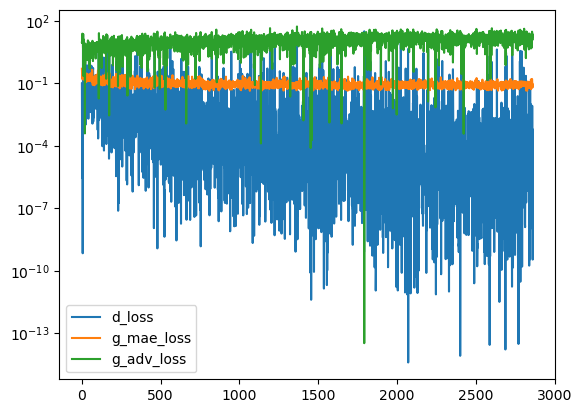

In [17]:
history = dngan.history
plt.plot(history.history['d'], label='d_loss')
plt.plot(history.history['g_mae'], label='g_mae_loss')
plt.plot(history.history['g_adv'], label='g_adv_loss')
plt.yscale('log')
plt.legend()
plt.show()

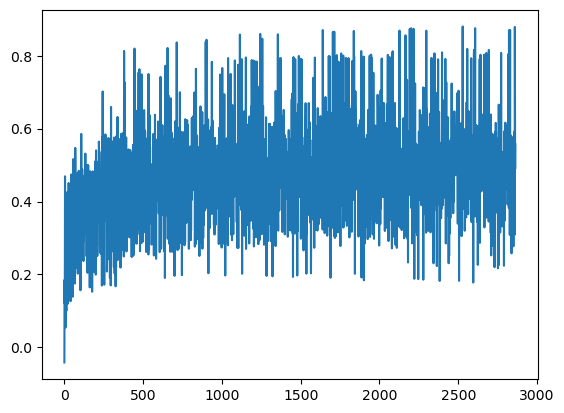

In [18]:
history = dngan.history
plt.plot(history.history['ssim'], label='ssim')

In [23]:
y = predict_all(dngan, images_noised[:200])

1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 42ms/step


mean PSNR=20.91222381591797
mean SSIM=0.4955570101737976


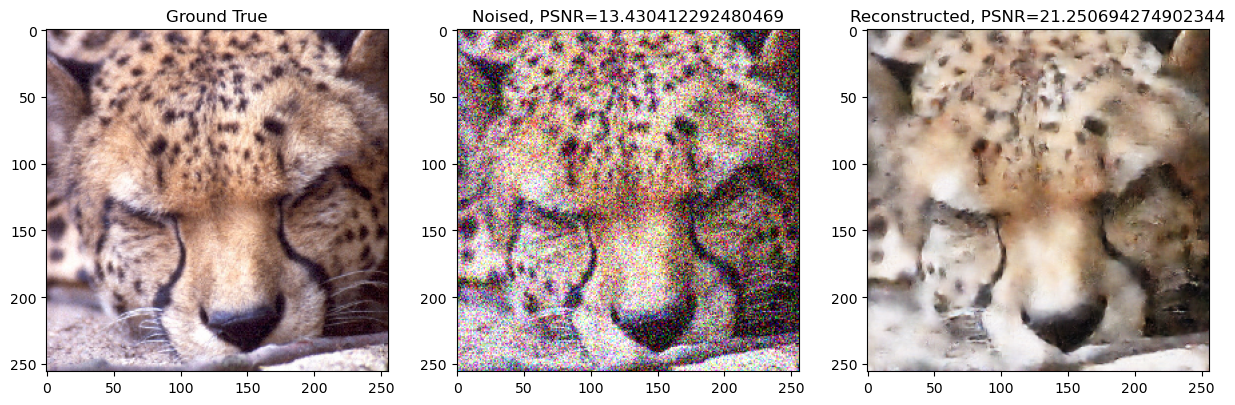

In [20]:
n=5
max_value=1
psnr, ssim = calc_mean_image_metrics(images_clear, y, max_value=max_value)
print (f'mean PSNR={psnr}')
print (f'mean SSIM={ssim}')
plot_result(images_clear[n],
            images_noised[n],
            y[n],
            max_value=max_value
           )

In [22]:
n=222
plot_result(images_clear[n],
           images_noised[n],
           y[n],
           max_value=1.)

IndexError: index 222 is out of bounds for axis 0 with size 10

In [ ]:
#G.save('gan/G')
#D.save('gan/D')
#dngan.fit(images_noised[:100], images_clear[:100], epochs=1)
dngan.save('gan/dngan')
#dngan.save_weights('gan/dngan_weights')